# **AI in Biomedicine**
## Final Project

**Professor:** Valentina Corino

**Team members:** Aurore Bechet de la Peschardière; Malvin; Olivia Gallego Toscano

**Matricola codes:** 276600; 276847; 276398

# 1. Dataset Preparation



*   Connect to Colab
*   Load the Exel file
*   Associate labels with images




####  **Set up the environment**

In [85]:
!pip install scikit-image==0.19.3
!pip install albumentations==1.3.0
!pip uninstall -y scikit-image albumentations
!pip install SimpleITK
!pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 37.3 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.25.0
    Uninstalling scikit-image-0.25.0:
      Successfully uninstalled scikit-image-0.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kraken 4.2.0 requires scikit-image<=0.19.2,>=0.17.0, but you have scikit-image 0.19.3 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
Found existing installation: scikit-image 0.19.3
Uninstalling scikit-image-0.19.3:
  Successfully uninstalled scikit-image-0.19.3
Found existing installation: albumentations 1.3.0
Uninstalling albumentations-1.3.0:
  Successfully uninstalled albumentations-1.3.0
Defaulting to user installation

In [3]:

import os
import numpy as np, os, sys, joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import math
import random
import sklearn
import timeit
import json
import warnings
from datetime import datetime
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from scipy import optimize
from scipy.signal import butter, lfilter, filtfilt
from scipy.io import loadmat
from scipy import signal


import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
import numpy as np
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.utils.class_weight import compute_class_weight

import warnings
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau


from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, ZeroPadding2D,Flatten, GlobalAveragePooling1D, GlobalAveragePooling2D, Conv2D,  Conv1D, MaxPooling2D, GlobalMaxPooling2D,MaxPooling1D, GlobalMaxPooling1D, Dropout,concatenate, BatchNormalization, Reshape
from keras.models import Model
from keras.utils import pad_sequences
from keras.callbacks import LearningRateScheduler


import keras.backend as K

from skimage.feature import graycomatrix, graycoprops
from albumentations import Compose, RandomCrop, HorizontalFlip, Normalize
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import SimpleITK as sitk

K.set_image_data_format('channels_last')

2025-01-11 14:35:00.615392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736602500.724183   26247 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736602500.754103   26247 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 14:35:01.055334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

#### **Import**

In [5]:
from pathlib import Path
import pandas as pd
import os

ROOT_PATH = Path('')

print("Files and folders in ROOT_PATH:", os.listdir(ROOT_PATH))

labels_file = ROOT_PATH / 'dataset_lung.xlsx'

data_folder = ROOT_PATH / 'Train'

labels_df = pd.read_excel(labels_file)

Files and folders in ROOT_PATH: ['fullslice_classification.csv', 'best_model.keras', 'Applied_AI_Proyect (1).pdf:Zone.Identifier', 'Applied_AI_Proyect (4).pdf:Zone.Identifier', 'rf_model_20250108_220809_model.joblib', 'weights_EfficientNetB3_finetuned.weights.h5', 'nodule_binary.joblib', 'lung_classifier.keras', 'dataset_lung_features_full_slice.csv', 'dataset_lung.xlsx:Zone.Identifier', 'Applied_AI_Proyect (2).pdf:Zone.Identifier', 'nodule_classification.csv', 'Applied_AI_Proyect (3).pdf:Zone.Identifier', 'rf_nodule_multiclass.joblib', 'rf_full_slice_multiclass.joblib', 'Applied_AI_Proyect (4).pdf', 'dataset_lung_features_nodule.csv', 'notebook_nodule_fs_ML.ipynb.url:Zone.Identifier', 'Applied_AI_Proyect (3).pdf', 'submission.ipynb', 'notebook_nodule_fs_ML.ipynb:Zone.Identifier', 'normalized_features.csv', 'Applied_AI_Proyect (2).pdf', 'Applied_AI_Proyect (1).pdf', 'dataset_lung_updated.csv', 'weights_EfficientNetV2B0_finetuned.weights.h5', 'light_lung_classifier.h5', 'dataset_lung.xl

In [6]:
labels_df['Full_slice'] = labels_df['Full_slice'].apply(lambda x: str(data_folder / x))
labels_df['Nodule'] = labels_df['Nodule'].apply(lambda x: str(data_folder / x))
labels_df['Malignancy'] = labels_df['TumorClass'].apply(lambda x: 0 if x in [1, 2, 3] else 1)
labels_df.to_csv('dataset_lung_updated.csv', index=False)
labels_df.head()

Full_slice                  Nodule  TumorClass  Malignancy
0  Train/pat1_fullslice.nrrd  Train/pat1_nodule.nrrd           5           1
1  Train/pat2_fullslice.nrrd  Train/pat2_nodule.nrrd           5           1
2  Train/pat3_fullslice.nrrd  Train/pat3_nodule.nrrd           2           0
3  Train/pat4_fullslice.nrrd  Train/pat4_nodule.nrrd           5           1
4  Train/pat5_fullslice.nrrd  Train/pat5_nodule.nrrd           4           1

# 2. Pre-Processing



*   Load NRRD files
*   Load images
*   Normalize image
*   Image sampling
*   Verification of data



####   **Load NRRD files**

In [7]:
print("Loading data...")
def load_nrrd(file_path):
    """
    Loads an NRRD file and returns a NumPy array.
    """
    try:
        image = sitk.ReadImage(file_path)
        array = sitk.GetArrayFromImage(image)
        return array
    except Exception as e:
        print(f"Error while loading {file_path}: {e}")
        return None

Loading data...


#### **Load images**   

In [8]:

import cv2

def load_images_and_labels(labels_df, target_size=(128, 128)):
    """
    Loads images (full slices and nodules) and their labels.
    Ensures all images are resized to a uniform target size.
    """
    full_slices = []
    nodules = []
    labels = labels_df['TumorClass'].tolist()

    for _, row in labels_df.iterrows():
        full_slice = load_nrrd(row['Full_slice'])
        nodule = load_nrrd(row['Nodule'])

        if full_slice is not None and nodule is not None:
            # Resize images to target size
            full_slice = cv2.resize(full_slice, target_size)
            nodule = cv2.resize(nodule, target_size)

            full_slices.append(full_slice)
            nodules.append(nodule)
        else:
            continue

    return np.array(full_slices), np.array(nodules), np.array(labels)


def get_labels(dataframe, column_name):
    """
    Returns a list of labels from a specific column in the DataFrame.
    """
    return dataframe[column_name].tolist()

Loading images...
Displaying examples for each class...


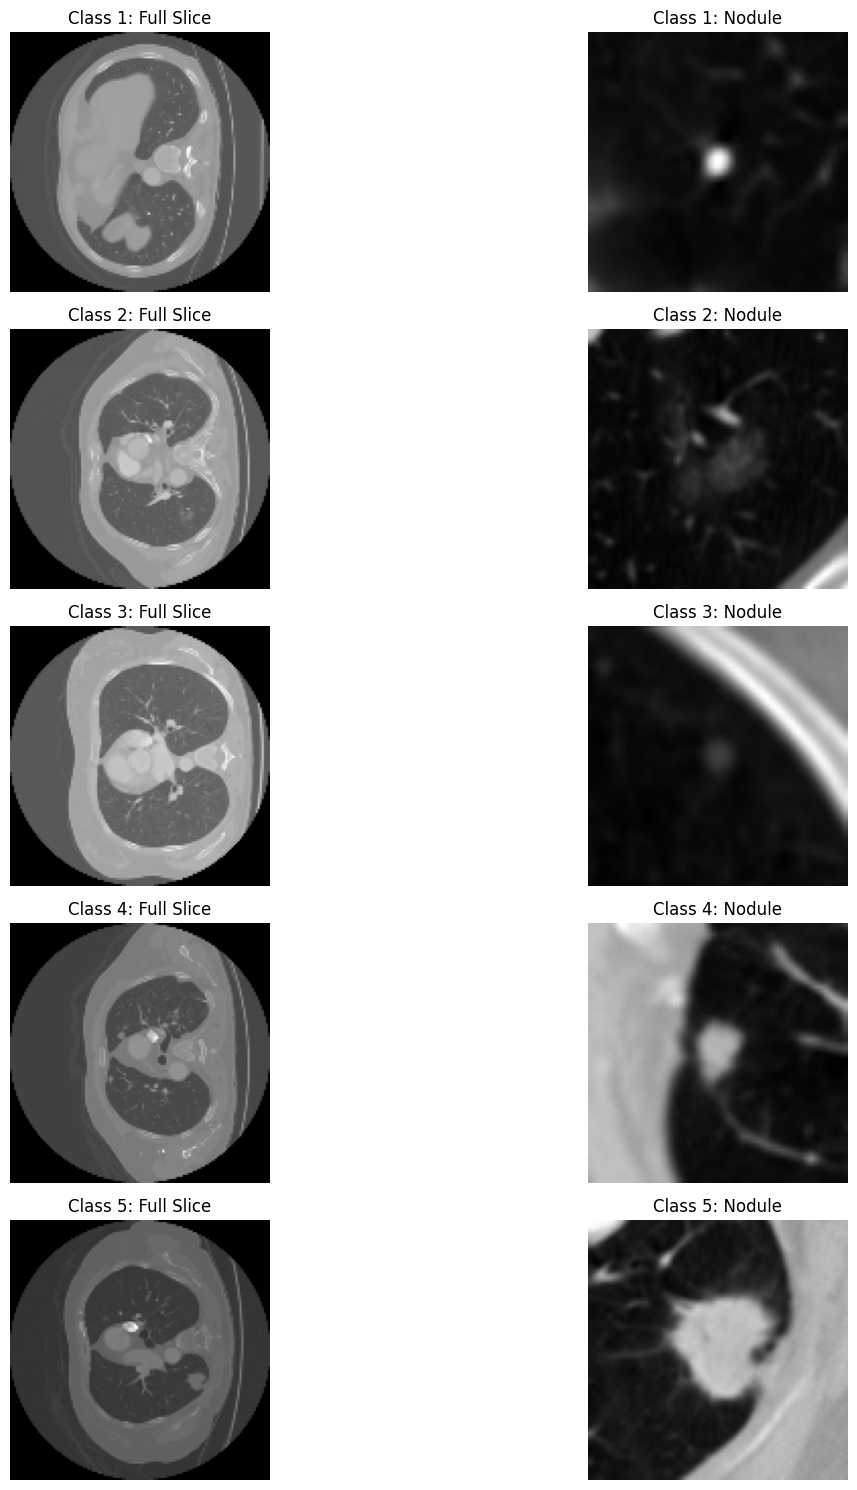

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def display_one_per_class(full_slices, nodules, labels, save_path=None):
    """
    Display one example image for each tumor class
    
    Args:
        full_slices: Array of full CT slice images
        nodules: Array of nodule images
        labels: Array of tumor class labels (1-5)
        save_path: Optional path to save the figure
    """
    # Get unique labels
    unique_labels = np.unique(labels)
    n_classes = len(unique_labels)
    
    # Create figure
    plt.figure(figsize=(15, 3*n_classes))
    
    # For each class
    for i, label in enumerate(unique_labels):
        # Get indices for current class
        class_indices = np.where(labels == label)[0]
        
        if len(class_indices) > 0:
            # Take first image of this class
            idx = class_indices[0]
            
            # Display full slice
            plt.subplot(n_classes, 2, 2*i + 1)
            plt.imshow(full_slices[idx], cmap='gray')
            plt.title(f'Class {label}: Full Slice')
            plt.axis('off')
            
            # Display nodule
            plt.subplot(n_classes, 2, 2*i + 2)
            plt.imshow(nodules[idx], cmap='gray')
            plt.title(f'Class {label}: Nodule')
            plt.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# Load and prepare data
print("Loading images...")
full_slices, nodules, labels = load_images_and_labels(labels_df)

# Normalize images
full_slices = full_slices / np.max(full_slices)
nodules = nodules / np.max(nodules)

# Display one example per class
print("Displaying examples for each class...")
display_one_per_class(full_slices, nodules, labels)

#### **Normalize images**   

In [10]:
def normalize_images(images):
    return images / 255.0

# Preprocess the images and we converte the tumor_classes into a NumPy array
full_slices, nodules, tumor_classes = load_images_and_labels(labels_df, target_size=(128, 128))
full_slices = normalize_images(full_slices)
nodules = normalize_images(nodules)

# Check shapes
print(f"Full slices shape: {full_slices.shape}")
print(f"Nodules shape: {nodules.shape}")

Full slices shape: (2363, 128, 128)
Nodules shape: (2363, 128, 128)


#### **Images samples**

In [11]:
# Select the first image paths for full slice and nodule
sample_fs_image_path = labels_df['Full_slice'][0]
print(f"Attempting to load full slice file: {sample_fs_image_path}")

sample_n_image_path = labels_df['Nodule'][0]
print(f"Attempting to load nodule file: {sample_n_image_path}")

# Load the images
sample_fs_image = load_nrrd(sample_fs_image_path)
sample_n_image = load_nrrd(sample_n_image_path)

if sample_fs_image is not None:
    print("Dimensions of the full slice image:", sample_fs_image.shape)
else:
    print(f"Failed to load full slice image: {sample_fs_image_path}")

if sample_n_image is not None:
    print("Dimensions of the nodule image:", sample_n_image.shape)
    print("Label of the nodule image:", tumor_classes[0])
else:
    print(f"Failed to load nodule image: {sample_n_image_path}")

Attempting to load full slice file: Train/pat1_fullslice.nrrd
Attempting to load nodule file: Train/pat1_nodule.nrrd
Dimensions of the full slice image: (512, 512)
Dimensions of the nodule image: (84, 92)
Label of the nodule image: 5


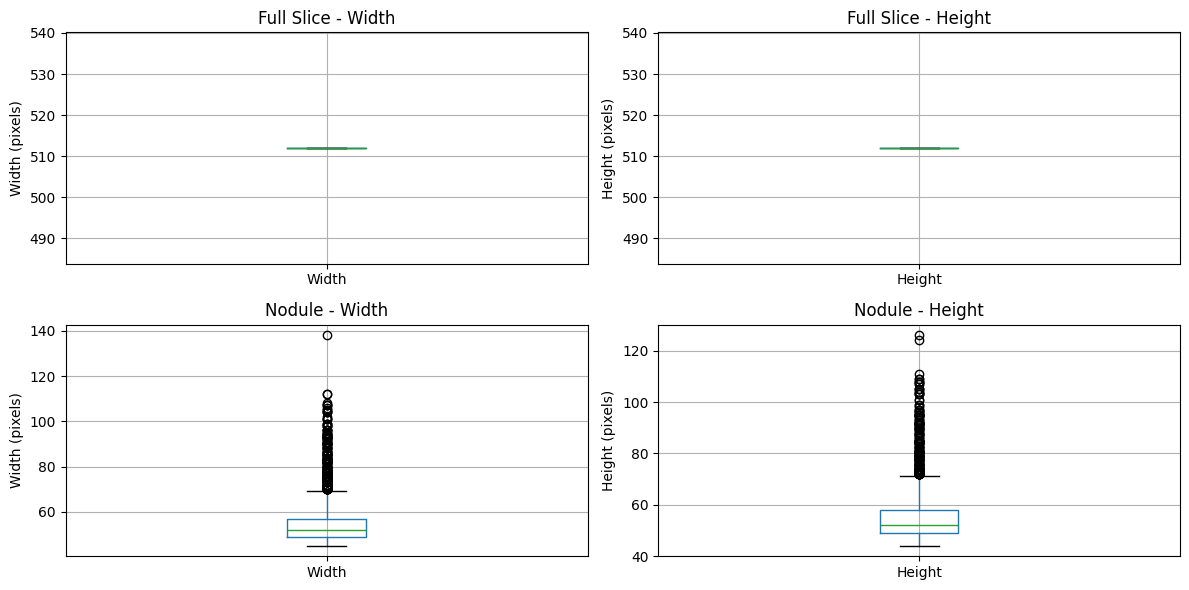

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Create lists to store image dimensions
full_slice_sizes = []
nodule_sizes = []

for i, row in labels_df.iterrows():
    fs_image_path = row['Full_slice']
    fs_image = load_nrrd(fs_image_path)
    if fs_image is not None:
        full_slice_sizes.append(fs_image.shape)

    n_image_path = row['Nodule']
    n_image = load_nrrd(n_image_path)
    if n_image is not None:
        nodule_sizes.append(n_image.shape)

# Convert the dimensions into separate DataFrames
full_slice_df = pd.DataFrame({
    'Width': [size[1] for size in full_slice_sizes],
    'Height': [size[0] for size in full_slice_sizes],
})
nodule_df = pd.DataFrame({
    'Width': [size[1] for size in nodule_sizes],
    'Height': [size[0] for size in nodule_sizes],
})

# Plot boxplots for Full_slice
plt.figure(figsize=(12, 6))

# Full_slice - Width
plt.subplot(2, 2, 1)
full_slice_df.boxplot(column='Width')
plt.title('Full Slice - Width')
plt.ylabel('Width (pixels)')

# Full_slice - Height
plt.subplot(2, 2, 2)
full_slice_df.boxplot(column='Height')
plt.title('Full Slice - Height')
plt.ylabel('Height (pixels)')

# Plot boxplots for Nodule
# Nodule - Width
plt.subplot(2, 2, 3)
nodule_df.boxplot(column='Width')
plt.title('Nodule - Width')
plt.ylabel('Width (pixels)')

# Nodule - Height
plt.subplot(2, 2, 4)
nodule_df.boxplot(column='Height')
plt.title('Nodule - Height')
plt.ylabel('Height (pixels)')

plt.tight_layout()
plt.show()


Loading images...

Class distribution:
Class 1: 244 samples
Class 2: 457 samples
Class 3: 1092 samples
Class 4: 418 samples
Class 5: 152 samples

Displaying two examples for each class...


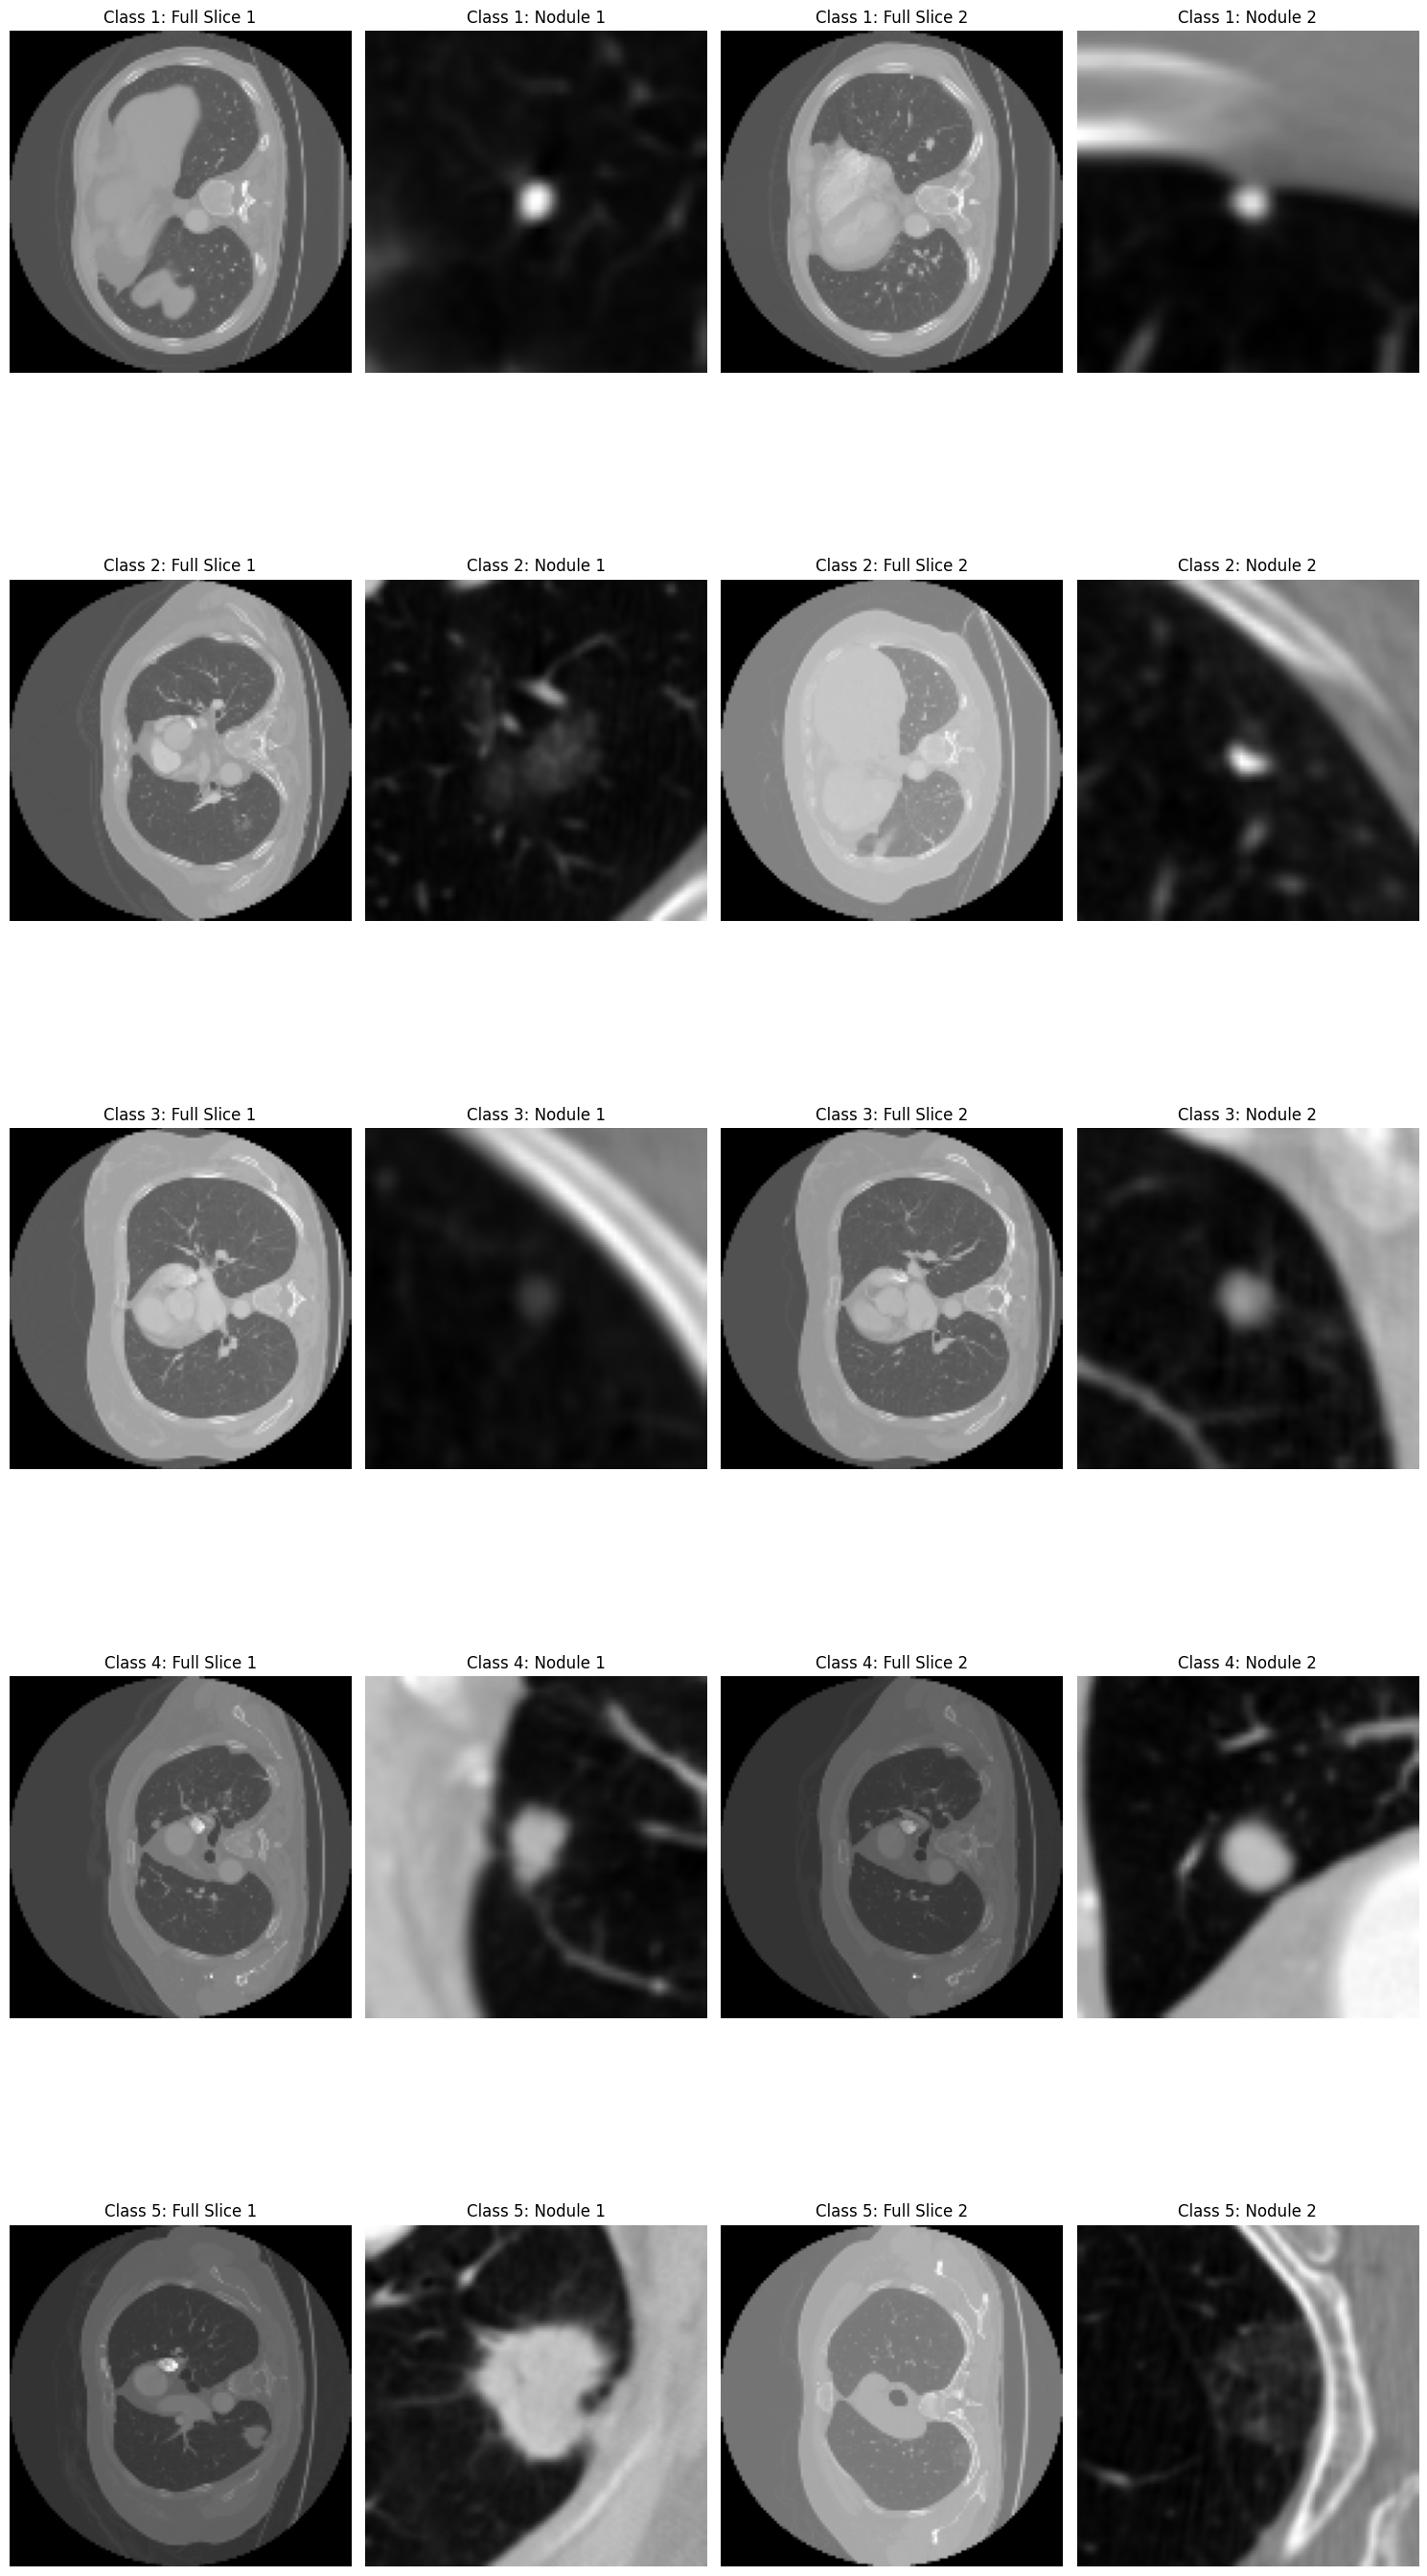

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def display_two_per_class(full_slices, nodules, labels, save_path=None):
    """
    Display two example images for each tumor class
    
    Args:
        full_slices: Array of full CT slice images
        nodules: Array of nodule images
        labels: Array of tumor class labels (1-5)
        save_path: Optional path to save the figure
    """
    # Get unique labels
    unique_labels = np.unique(labels)
    n_classes = len(unique_labels)
    
    # Create figure
    plt.figure(figsize=(15, 6*n_classes))
    
    # For each class
    for i, label in enumerate(unique_labels):
        # Get indices for current class
        class_indices = np.where(labels == label)[0]
        
        if len(class_indices) >= 2:
            # Take first two images of this class
            for j in range(2):
                idx = class_indices[j]
                
                # Display full slice
                plt.subplot(n_classes, 4, 4*i + 2*j + 1)
                plt.imshow(full_slices[idx], cmap='gray')
                plt.title(f'Class {label}: Full Slice {j+1}')
                plt.axis('off')
                
                # Display nodule
                plt.subplot(n_classes, 4, 4*i + 2*j + 2)
                plt.imshow(nodules[idx], cmap='gray')
                plt.title(f'Class {label}: Nodule {j+1}')
                plt.axis('off')
        
        elif len(class_indices) == 1:
            # If only one example available
            idx = class_indices[0]
            
            # Display full slice
            plt.subplot(n_classes, 4, 4*i + 1)
            plt.imshow(full_slices[idx], cmap='gray')
            plt.title(f'Class {label}: Full Slice (Only Example)')
            plt.axis('off')
            
            # Display nodule
            plt.subplot(n_classes, 4, 4*i + 2)
            plt.imshow(nodules[idx], cmap='gray')
            plt.title(f'Class {label}: Nodule (Only Example)')
            plt.axis('off')
            
            # Add text about missing example
            plt.subplot(n_classes, 4, 4*i + 3)
            plt.text(0.5, 0.5, 'No second example\navailable for this class', 
                    ha='center', va='center')
            plt.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()

# Load and prepare data
print("Loading images...")
full_slices, nodules, labels = load_images_and_labels(labels_df)

# Normalize images
full_slices = full_slices / np.max(full_slices)
nodules = nodules / np.max(nodules)

classes, counts = np.unique(labels, return_counts=True)
print("\nClass distribution:")
for class_label, count in zip(classes, counts):
    print(f"Class {class_label}: {count} samples")

print("\nDisplaying two examples for each class...")
display_two_per_class(full_slices, nodules, labels)

Number of elements in full_slice: 2363
Number of elements in nodule: 2363
Number of labels: 2363


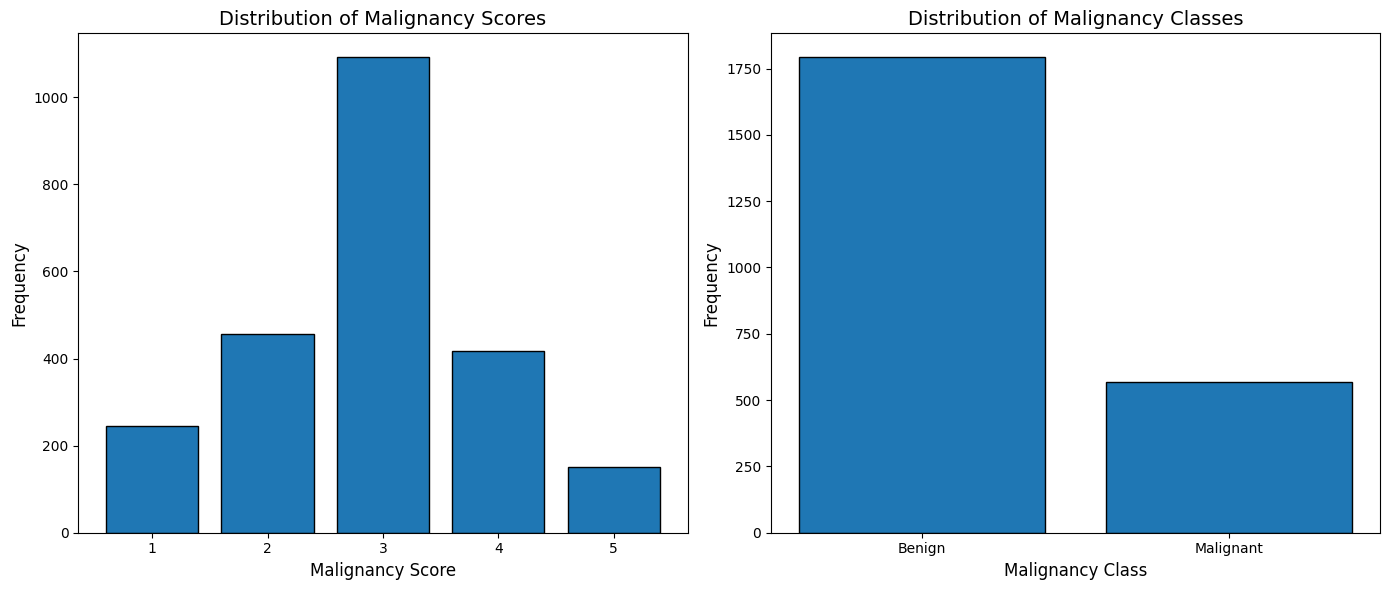

In [14]:
# Verify the correct length of each list
print(f"Number of elements in full_slice: {len(full_slices)}")
print(f"Number of elements in nodule: {len(nodules)}")
print(f"Number of labels: {len(tumor_classes)}")

# Verify that all labels are between 1 and 5
for i in range(len(tumor_classes)):
    if tumor_classes[i] < 1 or tumor_classes[i] > 5:
        print(f"Label number {i} is incorrect")

# Binary encoding of the malignancy scores
malignancy_class = []
for label in tumor_classes:
    if label <=3 :
        malignancy_class.append(0)  # Benign
    else :
        malignancy_class.append(1)  # Malignant

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for Malignancy Scores
axes[0].hist(tumor_classes, bins=range(1, 7), edgecolor='black', align='left', rwidth=0.8)
axes[0].set_title("Distribution of Malignancy Scores", fontsize=14)
axes[0].set_xlabel("Malignancy Score", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Histogram for Malignancy Classes
axes[1].hist(malignancy_class, bins=range(0, 3), edgecolor='black', align='left', rwidth=0.8)
axes[1].set_title("Distribution of Malignancy Classes", fontsize=14)
axes[1].set_xlabel("Malignancy Class", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Benign", "Malignant"])

# Annotate bars with percentages
def annotate_bars(ax, counts, total_samples):
    for i, count in enumerate(counts):
        percentage = (count / total_samples) * 100
        ax.text(i, count + 5, f"{percentage:.1f}%", ha='center', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


#### **Segmentation of nodule**

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from skimage.morphology import remove_small_objects, binary_closing
import pandas as pd
import cv2
import SimpleITK as sitk
import gc
from skimage import measure

# Free up memory at the beginning
try:
    gc.collect()
except Exception as e:
    print(f"Error during cleanup: {e}")

def load_nrrd_nodule(file_path, target_size=(128, 128)):
    """Loads an NRRD file and resizes the image."""
    try:
        image = sitk.ReadImage(file_path)
        array = sitk.GetArrayFromImage(image)
        array = cv2.resize(array, target_size)  # Resize the image
        return array.astype(np.float32)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.zeros(target_size, dtype=np.float32)  # Empty image in case of error

# Load images
images = []
labels = []

for index, row in labels_df.iterrows():
    image_path = row['Nodule']  # Load Nodule
    label = row['TumorClass'] - 1  # Adjust labels (1-5 to 0-4)
    image = load_nrrd_nodule(image_path, target_size=(128, 128))
    images.append(image)
    labels.append(label)

# Convert to NumPy arrays
images = np.stack(images, axis=0)
labels = np.array(labels)

# Normalize images
images = images / np.max(images)

# Display 5 Images and Their Masks
def display_images_and_masks(images, masks, num_to_display=5):
    """Display images and their corresponding masks."""
    plt.figure(figsize=(15, num_to_display * 3))
    
    for i in range(min(num_to_display, len(images))):
        # Original image
        plt.subplot(num_to_display, 2, i * 2 + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')
        
        # Segmented mask
        plt.subplot(num_to_display, 2, i * 2 + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [58]:
import numpy as np
from sklearn.cluster import KMeans
from skimage.morphology import remove_small_objects, binary_closing, disk, opening
from scipy import ndimage
from skimage.filters import gaussian

def improved_segmentation(image, n_clusters=2):
    """
    Improved segmentation with better preprocessing and postprocessing.
    """
    # Preprocessing
    image_smoothed = gaussian(image, sigma=0.5)
    
    # 2. Local contrast enhancement
    p2, p98 = np.percentile(image_smoothed, (2, 98))
    image_normalized = (image_smoothed - p2) / (p98 - p2)
    image_normalized = np.clip(image_normalized, 0, 1)
    
    # K-means with more features
    # Include spatial and intensity information
    h, w = image_normalized.shape
    y, x = np.mgrid[0:h, 0:w]
    features = np.column_stack([
        image_normalized.ravel(),
        (y.ravel() / h) * 0.2,  # Normalized coordinates with reduced weight
        (x.ravel() / w) * 0.2
    ])
    
    # Apply K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    segmented = labels.reshape(image.shape)
    
    # Ensure the foreground is white
    mean_intensities = [
        np.mean(image_normalized[segmented == i]) 
        for i in range(n_clusters)
    ]
    foreground_cluster = np.argmax(mean_intensities)
    segmented = (segmented == foreground_cluster).astype(int)
    
    # Improved postprocessing
    # 1. Remove small objects
    segmented = remove_small_objects(segmented.astype(bool), min_size=30)
    
    # 2. Morphological operations
    selem = disk(2)
    segmented = opening(segmented, selem)  # Removes small connections
    segmented = binary_closing(segmented, selem)  # Fills small holes
    
    # 3. Final hole filling
    segmented = ndimage.binary_fill_holes(segmented)
    
    return segmented.astype(int)

def process_batch(images):
    """
    Process a batch of images.
    """
    return [improved_segmentation(img) for img in images]


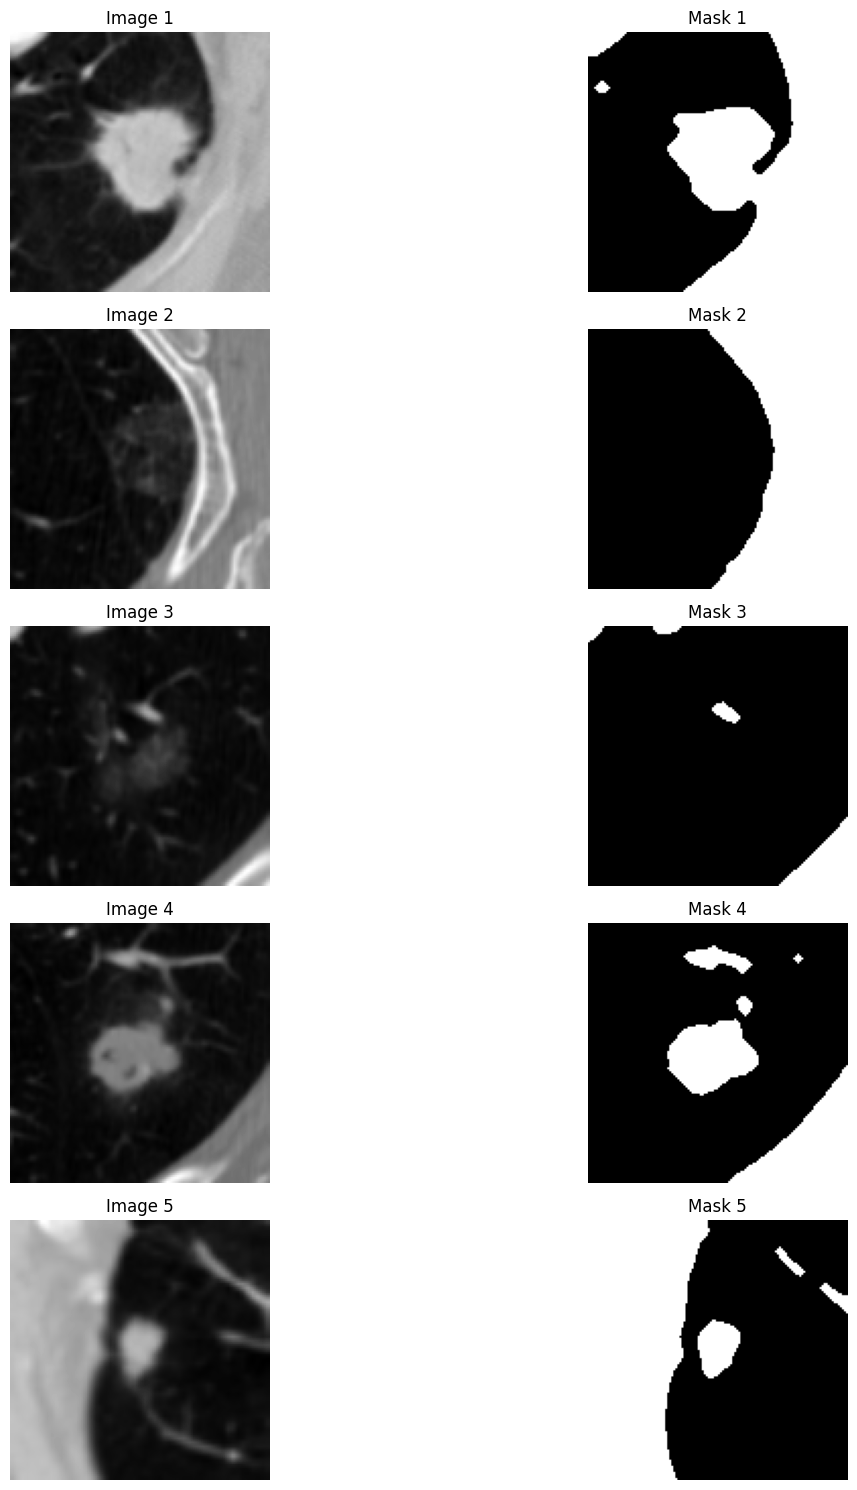

In [59]:
masks = process_batch(images)
display_images_and_masks(images, masks, num_to_display=5)

#### **Proportion of different classes :**

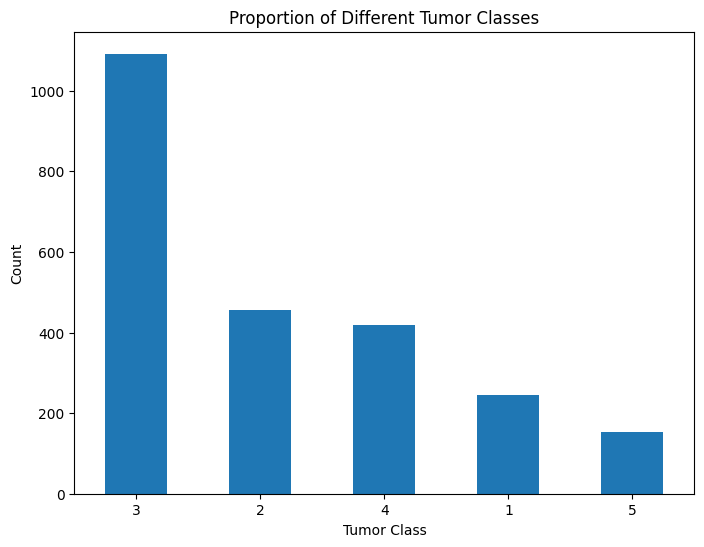

In [60]:
tumor_class_counts = labels_df['TumorClass'].value_counts()
plt.figure(figsize=(8, 6))
tumor_class_counts.plot(kind='bar', title='Proportion of Different Tumor Classes')
plt.xlabel('Tumor Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

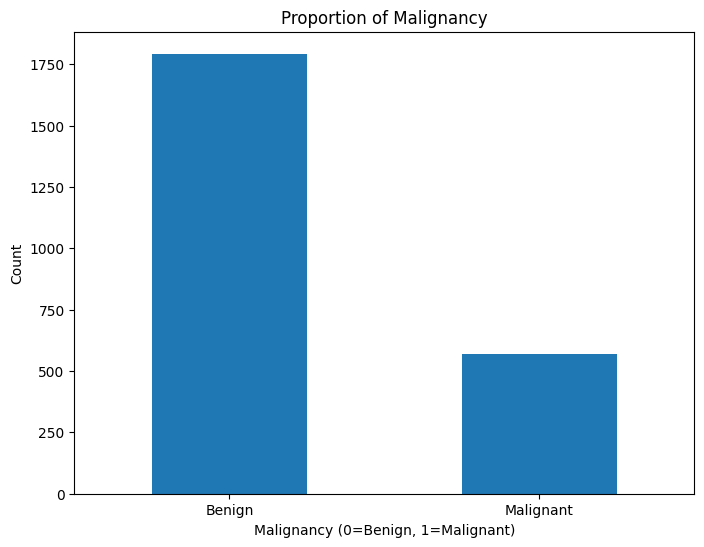

In [61]:
malignancy_counts = labels_df['Malignancy'].value_counts()
plt.figure(figsize=(8, 6))
malignancy_counts.plot(kind='bar', title='Proportion of Malignancy')
plt.xlabel('Malignancy (0=Benign, 1=Malignant)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Benign', 'Malignant'], rotation=0)
plt.show()

# 2. Feature Extraction

*   FOS: Mean, variance, skewness, etc.
*   Extract texture features: GLCM(contrast, homogeneity, etc.).
*   Wavelet: Capture multi-scale image features.
*   Storage of features


#### **First-Order Statistics (FOS)**   

In [15]:
def calculate_first_order_statistics(image):
    # Normalize pixel values to avoid negative values
    normalized_image = image - np.min(image) + 1e-10  # Shift all pixel values to be positive

    # Histogram and probability distribution
    hist, _ = np.histogram(normalized_image, bins=256, range=(np.min(normalized_image), np.max(normalized_image)), density=True)
    probability = hist / np.sum(hist)

    # Entropy calculation with stabilized log2
    safe_probability = np.clip(probability, 1e-10, None)  # Ensure no zero probabilities
    entropy = -np.sum(safe_probability * np.log2(safe_probability))

    stats = {
        'mean_intensity': np.mean(image),
        'variance_intensity': np.var(image),
        'skewness_intensity': np.mean((image - np.mean(image))**3) / (np.var(image)**1.5 + 1e-10),  # Add small constant to avoid division by zero
        'kurtosis_intensity': np.mean((image - np.mean(image))**4) / (np.var(image)**2 + 1e-10),  # Add small constant to avoid division by zero
        'min_intensity': np.min(image),
        'max_intensity': np.max(image),
        'entropy': entropy
    }
    return stats

# Example with the first full slice image
fos_features = calculate_first_order_statistics(sample_fs_image)
print(fos_features)

{'mean_intensity': -858.1303291320801, 'variance_intensity': 567743.7300502977, 'skewness_intensity': -0.20602393172380049, 'kurtosis_intensity': 2.42761754247465, 'min_intensity': -2048, 'max_intensity': 3071, 'entropy': 4.722227709502954}


####  **Textural Features**

In [16]:
from skimage.feature import graycomatrix, graycoprops 
def calculate_glcm_features(image, distances, angles):
    # Calculate the Gray-Level Co-occurrence Matrix (GLCM)
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Extract GLCM properties
    features = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
        'ASM': graycoprops(glcm, 'ASM').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean(),
    }
    return features

# Example usage with the first full slice image
glcm_features = calculate_glcm_features(sample_fs_image.astype(np.uint8), distances=[1, 2], angles=[0, np.pi/4])
print(glcm_features)


{'contrast': 2715.2849718604193, 'dissimilarity': 27.869842380091267, 'homogeneity': 0.2571578977571659, 'ASM': 0.04457609631311122, 'energy': 0.21112635746739442, 'correlation': 0.7505924616390648}


####  **Wavelet** 

In [17]:
import pywt

def calculate_wavelet_features(image):
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs
    features = {
        'approx_mean': np.mean(cA),
        'horizontal_detail_mean': np.mean(cH),
        'vertical_detail_mean': np.mean(cV),
        'diagonal_detail_mean': np.mean(cD),
    }
    return features

# Example usage with the first full slice image
wavelet_features = calculate_wavelet_features(sample_fs_image)
print(wavelet_features)


{'approx_mean': -1716.2606582641602, 'horizontal_detail_mean': -0.08129119873046875, 'vertical_detail_mean': 0.013618469238281264, 'diagonal_detail_mean': 0.022972106933593653}


### Additional nodule features

In [65]:
from skimage.measure import label, regionprops

import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import convex_hull_image
from scipy.ndimage import gaussian_gradient_magnitude

def calculate_morphological_features(nodule_image):
    """
    Calculate morphological features from binary mask
    """
    # Ensure image is binary
    binary_image = nodule_image > 0
    labeled_nodule = label(binary_image)
    properties = regionprops(labeled_nodule)
    
    features = {}
    
    if properties:
        prop = properties[0]
        
        # 1. Basic measurements
        features['area'] = prop.area
        features['perimeter'] = prop.perimeter
        features['diameter'] = prop.equivalent_diameter
        
        # 2. Shape descriptors
        features['circularity'] = (4 * np.pi * prop.area) / (prop.perimeter ** 2) if prop.perimeter > 0 else 0
        features['irregularity'] = prop.perimeter / (2 * np.sqrt(np.pi * prop.area))
        features['elongation'] = prop.major_axis_length / prop.minor_axis_length if prop.minor_axis_length > 0 else 0
        
        # 3. Complexity descriptors
        convex_hull = convex_hull_image(binary_image)
        features['convexity'] = prop.area / np.sum(convex_hull) if np.sum(convex_hull) > 0 else 0
        features['solidity'] = prop.solidity
        
        # 4. Edge characteristics
        gradient = gaussian_gradient_magnitude(nodule_image.astype(float), sigma=1)
        edge_mask = binary_image ^ ndimage.binary_erosion(binary_image)
        if np.any(edge_mask):
            features['edge_gradient'] = np.mean(gradient[edge_mask])
            features['spiculation'] = np.std(gradient[edge_mask])
        else:
            features['edge_gradient'] = 0
            features['spiculation'] = 0
        
        # 5. Position and orientation
        features['eccentricity'] = prop.eccentricity
        features['orientation'] = prop.orientation
        features['aspect_ratio'] = max(prop.bbox[2:]) / min(prop.bbox[2:]) if min(prop.bbox[2:]) > 0 else 0
        features['extent'] = prop.extent
    
    return features

def calculate_intensity_features(nodule_image):
    features = {
        'mean_HU': np.mean(nodule_image),
        'std_HU': np.std(nodule_image),
        'max_HU': np.max(nodule_image),
        'min_HU': np.min(nodule_image),
    }
    return features

####   **Store Full slices features**

In [66]:
columns_fos = ['mean_intensity', 'variance_intensity', 'skewness_intensity', 'kurtosis_intensity',
               'min_intensity', 'max_intensity', 'entropy']
columns_glcm = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
columns_wavelet = ['approx_mean', 'horizontal_detail_mean', 'vertical_detail_mean', 'diagonal_detail_mean']

df_full_slice = labels_df.copy()

# Add columns to the DataFrame
for col in columns_fos + columns_glcm + columns_wavelet:
    df_full_slice[col] = None

# Iterate through each row and calculate features
for index, row in df_full_slice.iterrows():
    # Load the Full Slice image
    full_slice_image = load_nrrd(row['Full_slice'])

    # Calculate FOS features
    fos = calculate_first_order_statistics(full_slice_image)
    for key, value in fos.items():
        df_full_slice.loc[index, key] = value

    # Calculate GLCM features
    glcm = calculate_glcm_features(full_slice_image.astype(np.uint8), distances=[1, 2], angles=[0, np.pi/4])
    for key, value in glcm.items():
        df_full_slice.loc[index, key] = value

    # Calculate Wavelet features
    wavelet = calculate_wavelet_features(full_slice_image)
    for key, value in wavelet.items():
        df_full_slice.loc[index, key] = value

# Save the completed DataFrame
df_full_slice.to_csv('dataset_lung_features_full_slice.csv', index=False)


#### **Store Nodules features**

In [67]:

df_full_nodule = labels_df.copy()

columns_fos = ['mean_intensity', 'variance_intensity', 'skewness_intensity', 'kurtosis_intensity',
               'min_intensity', 'max_intensity', 'entropy']
columns_glcm = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
columns_wavelet = ['approx_mean', 'horizontal_detail_mean', 'vertical_detail_mean', 'diagonal_detail_mean']

# Add columns to the DataFrame
for col in columns_fos + columns_glcm + columns_wavelet:
    df_full_nodule[col] = None

# Iterate through each row and calculate features
for index, row in df_full_nodule.iterrows():
    # Load the Nodule image
    nodule_image = load_nrrd(row['Nodule'])

    # Calculate FOS features
    fos = calculate_first_order_statistics(nodule_image)
    for key, value in fos.items():
        df_full_nodule.loc[index, key] = value

    # Calculate GLCM features
    glcm = calculate_glcm_features(nodule_image.astype(np.uint8), distances=[1, 2], angles=[0, np.pi/4])
    for key, value in glcm.items():
        df_full_nodule.loc[index, key] = value

    # Calculate Wavelet features
    wavelet = calculate_wavelet_features(nodule_image)
    for key, value in wavelet.items():
        df_full_nodule.loc[index, key] = value

# Save the completed DataFrame
df_full_nodule.to_csv('dataset_lung_features_nodule.csv', index=False)



In [68]:
columns_fos_mapping = {col: f"{col}_nodule" for col in columns_fos}
columns_glcm_mapping = {col: f"{col}_nodule" for col in columns_glcm}
columns_wavelet_mapping = {col: f"{col}_nodule" for col in columns_wavelet}

all_mappings = {**columns_fos_mapping, **columns_glcm_mapping, **columns_wavelet_mapping}

df_full_nodule = df_full_nodule.rename(columns=all_mappings)

print("Nouvelles colonnes :")
print(df_full_nodule.columns.tolist())

Nouvelles colonnes :
['Full_slice', 'Nodule', 'TumorClass', 'Malignancy', 'mean_intensity_nodule', 'variance_intensity_nodule', 'skewness_intensity_nodule', 'kurtosis_intensity_nodule', 'min_intensity_nodule', 'max_intensity_nodule', 'entropy_nodule', 'contrast_nodule', 'dissimilarity_nodule', 'homogeneity_nodule', 'ASM_nodule', 'energy_nodule', 'correlation_nodule', 'approx_mean_nodule', 'horizontal_detail_mean_nodule', 'vertical_detail_mean_nodule', 'diagonal_detail_mean_nodule']


In [69]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import SimpleITK as sitk
import cv2
from skimage.measure import label, regionprops
from skimage.morphology import convex_hull_image
from scipy.ndimage import gaussian_gradient_magnitude
from sklearn.cluster import KMeans
from skimage.morphology import remove_small_objects, binary_closing, disk, opening
from scipy import ndimage
from skimage.filters import gaussian

def process_dataset_with_masks(labels_df):
    """
    Process the entire dataset and extract morphological features from segmentation masks
    """
    # Initialize feature columns
    df_full_nodule = labels_df.copy()
    
    # Define all feature columns
    columns_morphological = [
        'area', 'perimeter', 'diameter', 'circularity', 'irregularity',
        'elongation', 'convexity', 'solidity', 'edge_gradient', 'spiculation',
        'eccentricity', 'orientation', 'aspect_ratio', 'extent'
    ]
    
    # Add new columns
    for col in columns_morphological:
        df_full_nodule[col] = None
    
    # Process each image
    print("Processing images and extracting features...")
    for index, row in tqdm(df_full_nodule.iterrows(), total=len(df_full_nodule)):
        # Load and process image
        image = load_nrrd_nodule(row['Nodule'])
        
        # Generate mask using improved segmentation
        mask = improved_segmentation(image)
        
        # Calculate morphological features from mask
        features = calculate_morphological_features(mask)
        
        # Store features in dataframe
        for feature_name, feature_value in features.items():
            df_full_nodule.loc[index, feature_name] = feature_value

    
    return df_full_nodule



# Process dataset and extract features
df_with_features = process_dataset_with_masks(df_full_nodule)

# Save results
output_filename = 'dataset_lung_features_nodule_extended.csv'
df_with_features.to_csv(output_filename, index=False)
print(f"\nResults saved to {output_filename}")

# Print summary statistics
print("\nFeature statistics:")
print(df_with_features[['area', 'circularity', 'irregularity', 'spiculation']].describe())
        


Processing images and extracting features...


100%|██████████| 2363/2363 [01:16<00:00, 30.95it/s]


Results saved to dataset_lung_features_nodule_extended.csv

Feature statistics:
          area  circularity  irregularity  spiculation
count   2363.0  2363.000000   2363.000000  2363.000000
unique  1713.0  2288.000000   2286.000000  2363.000000
top       36.0     1.276272      0.885173     0.181146
freq      12.0    10.000000     10.000000     1.000000


#### Merge both

In [70]:
df_all = pd.merge(df_full_slice, df_with_features, on=['Full_slice', 'Nodule', 'TumorClass','Malignancy'], how='inner')

df_all.to_csv('dataset_lung_features_all.csv', index=False)


#### **Feature preparation**  

In [19]:

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import pandas as pd

# Load the Extracted Features
df_full_slice = pd.read_csv('dataset_lung_features_full_slice.csv')
df_full_nodule = pd.read_csv('dataset_lung_features_nodule_extended.csv')
df_all = pd.read_csv('dataset_lung_features_all.csv')

# Separate Features and Labels
X_full_slice = df_full_slice.drop(columns=['Full_slice', 'Nodule', 'TumorClass','Malignancy'])  # Features
y_full_slice = df_full_slice['TumorClass']  # Labels

X_full_nodule = df_full_nodule.drop(columns=['Full_slice', 'Nodule', 'TumorClass','Malignancy'])  # Features
y_full_nodule = df_full_nodule['TumorClass']  # Labels

X_full_all = df_all.drop(columns=['Full_slice', 'Nodule', 'TumorClass','Malignancy'])  # Features
y_full_all = df_all['TumorClass']  # Labels

# Apply KNN Imputer to handle NaN values
imputer = KNNImputer(n_neighbors=5)
X_full_slice_imputed = pd.DataFrame(imputer.fit_transform(X_full_slice), columns=X_full_slice.columns)
X_full_nodule_imputed = pd.DataFrame(imputer.fit_transform(X_full_nodule), columns=X_full_nodule.columns)
X_full_all_imputed = pd.DataFrame(imputer.fit_transform(X_full_all), columns=X_full_all.columns)



# Verify that no NaN values remain
print(X_full_slice_imputed.isnull().sum().sum(), "NaN values remaining in the dataset.")  # Should print 0
print(X_full_nodule_imputed.isnull().sum().sum(), "NaN values remaining in the dataset.")  # Should print 0

print(X_full_all_imputed.isnull().sum().sum(), "NaN values remaining in the dataset.")  # Should print 0

# Split the Data into Training and Testing Sets
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
    X_full_slice_imputed, y_full_slice, test_size=0.2, stratify=y_full_slice, random_state=SEED
)
X_train_nod, X_test_nod, y_train_nod, y_test_nod = train_test_split(
    X_full_nodule_imputed, y_full_nodule, test_size=0.2, stratify=y_full_nodule, random_state=SEED
)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_full_all_imputed, y_full_all, test_size=0.2, stratify=y_full_all, random_state=SEED
)


0 NaN values remaining in the dataset.
0 NaN values remaining in the dataset.
0 NaN values remaining in the dataset.


# 2. Tools for analysis :

In [18]:
def plot_feature_importances(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features = min(10, len(importances))
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(top_features), importances[indices[:top_features]], align="center")
    plt.xticks(range(top_features), feature_names[indices[:top_features]], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()


# 3. Classification Task Full Slice

*   Baseline Models: Logistic Regression and Decision Tree
*   Advanced Models: SVM and Random Forest
*   Deep Learning: CNN

### Baseline Models

Compute the real class weights to take them into account

In [9]:
from collections import Counter

class_counts = Counter(y_train_nod)
total_samples = len(y_train_nod)

class_weight = {cls: total_samples / count for cls, count in class_counts.items()}

print("Class Weights:", class_weight)

Class Weights: {4: 5.658682634730539, 3: 2.1649484536082473, 1: 9.692307692307692, 2: 5.163934426229508, 5: 15.491803278688524}


#### **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logreg = LogisticRegression(max_iter=1000, random_state=SEED, class_weight=class_weight)
logreg.fit(X_train_fs, y_train_fs)

y_pred = logreg.predict(X_test_fs)
print("Accuracy:", accuracy_score(y_test_fs, y_pred))
print("Classification Report:\n", classification_report(y_test_fs, y_pred))


Accuracy: 0.1522198731501057
Classification Report:
               precision    recall  f1-score   support

           1       0.12      0.14      0.13        49
           2       0.15      0.22      0.18        91
           3       0.45      0.09      0.15       219
           4       0.19      0.19      0.19        84
           5       0.07      0.33      0.11        30

    accuracy                           0.15       473
   macro avg       0.19      0.19      0.15       473
weighted avg       0.29      0.15      0.16       473



/home/malvin/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We have seen that Logistic Regression is perfoming poorly for this dataset, with just a 15% of accuracy.

#### **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train_fs, y_train_fs)

y_pred = tree.predict(X_test_fs)
print("Accuracy:", accuracy_score(y_test_fs, y_pred))
print("Classification Report:\n", classification_report(y_test_fs, y_pred))


Accuracy: 0.2938689217758985
Classification Report:
               precision    recall  f1-score   support

           1       0.17      0.16      0.16        49
           2       0.22      0.23      0.23        91
           3       0.44      0.47      0.45       219
           4       0.10      0.08      0.09        84
           5       0.03      0.03      0.03        30

    accuracy                           0.29       473
   macro avg       0.19      0.20      0.19       473
weighted avg       0.28      0.29      0.29       473



We can observe that the Decision Tree performs worse than Logistic Regression, achieving only 29% accuracy while also suffering from overfitting and issues with imbalanced classes.
Based on this, we conclude that baseline models are insufficient for our dataset.
Therefore, we will proceed to train advanced models to address these challenges and improve performance.

### Advanced Models

#### **SVM**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm = SVC(kernel='linear', class_weight=class_weight, random_state=SEED)
svm.fit(X_train_fs, y_train_fs)

y_pred = svm.predict(X_test_fs)
print("SVM Accuracy:", accuracy_score(y_test_fs, y_pred))
print("SVM Classification Report:\n", classification_report(y_test_fs, y_pred))


The SVM model didn't perform in our case.

#### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=SEED, class_weight=class_weight)
rf.fit(X_train_fs, y_train_fs)

y_pred = rf.predict(X_test_fs)
print("Random Forest Accuracy:", accuracy_score(y_test_fs, y_pred))
print("Random Forest Classification Report:\n", classification_report(y_test_fs, y_pred))


Random Forest Accuracy: 0.45665961945031713
Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.47      0.18      0.26        49
           2       0.36      0.18      0.24        91
           3       0.49      0.83      0.61       219
           4       0.28      0.11      0.16        84
           5       0.00      0.00      0.00        30

    accuracy                           0.46       473
   macro avg       0.32      0.26      0.25       473
weighted avg       0.39      0.46      0.38       473



The Random Forest model achieved an accuracy of 25% in f1-score.


In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from bayes_opt import BayesianOptimization
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=SEED,
        class_weight=class_weight
    )

    model.fit(X_train_fs, y_train_fs)
    y_pred = model.predict(X_train_fs)
    accuracy = accuracy_score(y_train_fs, y_pred)

    return accuracy

pbounds = {
    'n_estimators': (50, 300),
    'max_depth': (5, 30),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}

optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=pbounds,
    random_state=SEED
)

optimizer.maximize(init_points=10, n_iter=30)

best_params = optimizer.max['params']
print("Best Parameters:", best_params)

best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    class_weight=class_weight
)

best_rf.fit(X_train_fs, y_train_fs)
y_pred = best_rf.predict(X_test_fs)
print("Tuned Random Forest Accuracy:", accuracy_score(y_test_fs, y_pred))
print("Tuned Random Forest Classification Report:\n", classification_report(y_test_fs, y_pred))


|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.7857    | 14.36     | 9.556     | 15.18     | 199.7     |
| 2         | 0.8545    | 8.9       | 2.404     | 3.046     | 266.5     |
| 3         | 0.8614    | 20.03     | 7.373     | 2.371     | 292.5     |
| 4         | 0.9921    | 25.81     | 2.911     | 5.273     | 95.85     |
| 5         | 0.8989    | 12.61     | 5.723     | 9.775     | 122.8     |
| 6         | 0.9841    | 20.3      | 2.255     | 7.259     | 141.6     |
| 7         | 0.8233    | 16.4      | 8.067     | 5.594     | 178.6     |
| 8         | 0.9519    | 19.81     | 1.418     | 12.94     | 92.63     |
| 9         | 0.5376    | 6.626     | 9.54      | 19.38     | 252.1     |
| 10        | 0.8921    | 12.62     | 1.879     | 14.32     | 160.0     |
| 11        | 0.991     | 28.66     | 2.29      | 2.035     | 69.22     |
| 12        | 0.4439    | 5.158     | 

#### **Crossvalidate model to obtain the best fit**

In [90]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=SEED, class_weight=class_weight),
                           param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_fs, y_train_nod)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test_fs)
print("Tuned Random Forest Accuracy:", accuracy_score(y_test_fs, y_pred))
print("Tuned Random Forest Classification Report:\n", classification_report(y_test_fs, y_pred))


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest Accuracy: 0.4418604651162791
Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.55      0.22      0.32        49
           2       0.24      0.12      0.16        91
           3       0.47      0.80      0.59       219
           4       0.35      0.13      0.19        84
           5       0.00      0.00      0.00        30

    accuracy                           0.44       473
   macro avg       0.32      0.26      0.25       473
weighted avg       0.38      0.44      0.37       473



#### **Improve random Forest :**

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np


X_temp_fs, X_unseen_fs, y_temp_fs, y_unseen_fs = train_test_split(
    X_full_slice, y_full_slice, 
    test_size=0.1, # 10% for unseen
    stratify=y_full_slice, 
    random_state=SEED
)


imputer = KNNImputer(n_neighbors=5)

X_temp_fs_imputed = pd.DataFrame(imputer.fit_transform(X_temp_fs), columns=X_temp_fs.columns)
X_unseen_fs_imputed = pd.DataFrame(imputer.transform(X_unseen_fs), columns=X_unseen_fs.columns)

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
    X_temp_fs_imputed, y_temp_fs,
    test_size=0.2,
    stratify=y_temp_fs,
    random_state=SEED
)



[I 2025-01-11 14:43:29,575] A new study created in memory with name: no-name-4cc417aa-7ba4-4f1a-afcb-389ebf4a5c64



Starting hyperparameter optimization...
Number of features: 17
Number of samples: 1700
Number of classes: 5

Class distribution:
Class 1: 176
Class 2: 329
Class 3: 785
Class 4: 301
Class 5: 109


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-01-11 14:43:34,322] Trial 0 finished with value: 0.2720730729403059 and parameters: {'n_estimators': 306, 'max_depth': 36, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.2720730729403059.
[I 2025-01-11 14:43:35,922] Trial 1 finished with value: 0.265347763966542 and parameters: {'n_estimators': 120, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.2720730729403059.
[I 2025-01-11 14:43:39,354] Trial 2 finished with value: 0.2535560519795791 and parameters: {'n_estimators': 270, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.2720730729403059.
[I 2025-01-11 14:43:42,437] Trial 3 finished with value: 0.2653817983796281 and parameters: {'n_estimators': 187, 'max_depth': 44, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_featur

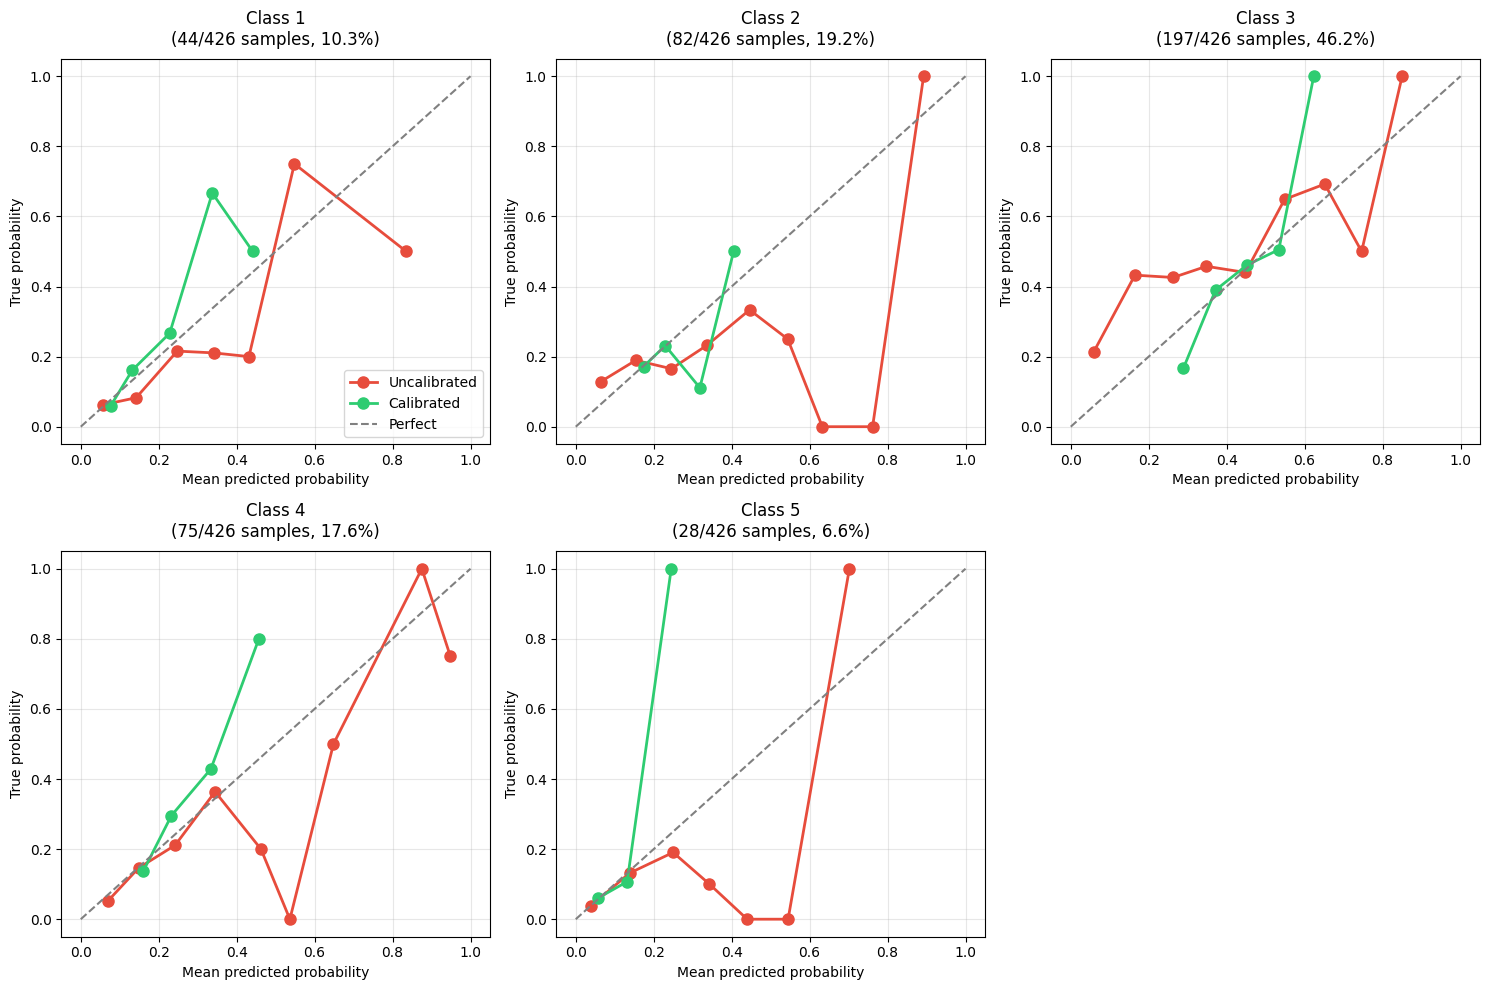

No predictions met the confidence threshold of 0.8
No predictions met the confidence threshold of 0.8

Training the model on the full dataset...
Training on the full dataset is complete.
Model saved to: rf_full_dataset_trained.joblib


In [23]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import f1_score, accuracy_score, classification_report, make_scorer, brier_score_loss, roc_auc_score
import joblib
import optuna
import matplotlib.pyplot as plt

class RandomForestOptimizer:
    def __init__(self, X_train, y_train, X_test, y_test, X_unseen, y_unseen, random_state=42):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_unseen = X_unseen
        self.y_unseen = y_unseen
        self.random_state = random_state
        self.best_model = None
        self.study = None
        self.calibrated_model = None
        self.n_classes = len(np.unique(y_train))
        self.class_weight = 'balanced'
        self.class_labels = list(range(1, 6))  # Classes from 1 to 5

    def objective(self, trial):
        """Objective function for Optuna optimization"""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': self.class_weight,
            'random_state': self.random_state,
            'n_jobs': -1
        }
        
        model = RandomForestClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        try:
            # Using macro F1 score for multi-class
            f1_scores = cross_val_score(
                model, self.X_train, self.y_train, 
                scoring=make_scorer(f1_score, average='macro'),
                cv=cv
            )
            return np.mean(f1_scores)
        except Exception as e:
            print(f"Error during cross validation: {str(e)}")
            return float('-inf')

    def optimize(self, n_trials=100):
        """Run the optimization process"""
        print("\nStarting hyperparameter optimization...")
        print(f"Number of features: {self.X_train.shape[1]}")
        print(f"Number of samples: {self.X_train.shape[0]}")
        print(f"Number of classes: {self.n_classes}")
        print("\nClass distribution:")
        
        # Modified to show distribution for classes 1-5
        class_counts = np.bincount(self.y_train, minlength=6)[1:]  # Skip index 0
        for class_label, count in zip(self.class_labels, class_counts):
            print(f"Class {class_label}: {count}")
        
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=n_trials, show_progress_bar=True)
        self.study = study
        
        best_params = study.best_params
        best_params.update({
            'class_weight': self.class_weight,
            'random_state': self.random_state,
            'n_jobs': -1
        })
        
        print("\nBest parameters:", best_params)
        print(f"Best macro F1-score: {study.best_value:.4f}")
        
        self.best_model = RandomForestClassifier(**best_params)
        self.best_model.fit(self.X_train, self.y_train)
        
        return self

    def calibrate_probabilities(self, cv=5):
        """Calibrate probability estimates using Platt Scaling"""
        if self.best_model is None:
            raise ValueError("Model hasn't been optimized yet. Call optimize() first.")
        
        print("\nCalibrating probability estimates...")
        self.calibrated_model = CalibratedClassifierCV(
            self.best_model, 
            cv=cv, 
            method='sigmoid',
            n_jobs=-1
        )
        self.calibrated_model.fit(self.X_train, self.y_train)
        
        # Calculate calibration metrics for each class (1-5)
        for class_label in self.class_labels:
            # Convert to binary problem for each class
            y_test_binary = (self.y_test == class_label).astype(int)
            prob_pos_test = self.calibrated_model.predict_proba(self.X_test)[:, class_label-1]
            
            brier = brier_score_loss(y_test_binary, prob_pos_test)
            try:
                auc = roc_auc_score(y_test_binary, prob_pos_test)
                print(f"\nClass {class_label} Calibration Metrics:")
                print(f"Brier Score Loss: {brier:.4f} (lower is better)")
                print(f"ROC AUC Score: {auc:.4f}")
            except:
                print(f"\nClass {class_label}: Insufficient samples for ROC AUC calculation")
        
        return self

    def plot_calibration_curves(self):
        """Plot separate calibration curves for each class"""
        if self.calibrated_model is None:
            raise ValueError("Model hasn't been calibrated. Call calibrate_probabilities() first.")
        
        # Calculate number of rows and columns for subplots
        n_rows = 2  # For 5 classes, 3 in first row, 2 in second
        n_cols = 3
        
        # Create figure with subplots
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
        axes = axes.ravel()
        
        # Color scheme
        colors = ['#2ecc71', '#e74c3c']  # Green for calibrated, Red for uncalibrated
        
        for i, class_label in enumerate(self.class_labels):
            ax = axes[i]
            
            # Convert to binary problem for this class
            y_test_binary = (self.y_test == class_label).astype(int)
            
            # Get probabilities (adjust index for 1-based classes)
            prob_pos_uncal = self.best_model.predict_proba(self.X_test)[:, class_label-1]
            prob_pos_cal = self.calibrated_model.predict_proba(self.X_test)[:, class_label-1]
            
            # Calculate calibration curves
            prob_true_uncal, prob_pred_uncal = calibration_curve(
                y_test_binary, prob_pos_uncal, n_bins=10
            )
            prob_true_cal, prob_pred_cal = calibration_curve(
                y_test_binary, prob_pos_cal, n_bins=10
            )
            
            # Plot calibration curves
            ax.plot(prob_pred_uncal, prob_true_uncal, 
                   'o-', color=colors[1], label='Uncalibrated',
                   linewidth=2, markersize=8)
            ax.plot(prob_pred_cal, prob_true_cal, 
                   'o-', color=colors[0], label='Calibrated',
                   linewidth=2, markersize=8)
            ax.plot([0, 1], [0, 1], '--', color='gray', label='Perfect')
            
            # Calculate class distribution
            class_count = np.sum(y_test_binary)
            total_count = len(y_test_binary)
            class_percent = (class_count / total_count) * 100
            
            # Add title and class distribution info
            ax.set_title(f'Class {class_label}\n({class_count}/{total_count} samples, {class_percent:.1f}%)',
                        fontsize=12, pad=10)
            
            # Set labels and grid
            ax.set_xlabel('Mean predicted probability')
            ax.set_ylabel('True probability')
            ax.grid(True, alpha=0.3)
            
            # Add legend only to first subplot
            if i == 0:
                ax.legend(loc='lower right')
            
            # Set axis limits
            ax.set_xlim([-0.05, 1.05])
            ax.set_ylim([-0.05, 1.05])
        
        # Remove extra subplot
        fig.delaxes(axes[5])
        
        plt.tight_layout()
        plt.show()

    def predict_with_confidence(self, X):
        """Make predictions with confidence estimates"""
        if self.calibrated_model is None:
            raise ValueError("Model hasn't been calibrated. Call calibrate_probabilities() first.")
        
        probabilities = self.calibrated_model.predict_proba(X)
        predictions = np.argmax(probabilities, axis=1) + 1  # Add 1 to get classes 1-5
        confidences = np.max(probabilities, axis=1)
        
        return predictions, confidences, probabilities

    def evaluate_with_confidence(self, confidence_threshold=0.8, dataset="test"):
        """Evaluate model performance considering confidence threshold"""
        if self.calibrated_model is None:
            raise ValueError("Model hasn't been calibrated. Call calibrate_probabilities() first.")
        
        # Select evaluation dataset
        if dataset == "test":
            X_eval, y_eval = self.X_test, self.y_test
        elif dataset == "unseen":
            X_eval, y_eval = self.X_unseen, self.y_unseen
        else:
            raise ValueError("dataset must be 'test' or 'unseen'")
        
        # Get predictions and confidences
        y_pred, confidences, _ = self.predict_with_confidence(X_eval)
        
        # Filter predictions based on confidence threshold
        high_confidence_mask = confidences >= confidence_threshold
        
        if np.sum(high_confidence_mask) > 0:
            high_conf_accuracy = accuracy_score(
                y_eval[high_confidence_mask], 
                y_pred[high_confidence_mask]
            )
            high_conf_f1_macro = f1_score(
                y_eval[high_confidence_mask], 
                y_pred[high_confidence_mask], 
                average='macro'
            )
            high_conf_f1_weighted = f1_score(
                y_eval[high_confidence_mask], 
                y_pred[high_confidence_mask], 
                average='weighted'
            )
            coverage = np.mean(high_confidence_mask)
            
            print(f"\nConfidence Threshold Analysis for {dataset} set (threshold = {confidence_threshold}):")
            print(f"Coverage: {coverage:.2%} of samples")
            print(f"High-confidence Accuracy: {high_conf_accuracy:.4f}")
            print(f"High-confidence Macro F1-Score: {high_conf_f1_macro:.4f}")
            print(f"High-confidence Weighted F1-Score: {high_conf_f1_weighted:.4f}")
            
            print("\nDetailed Classification Report for high-confidence predictions:")
            print(classification_report(
                y_eval[high_confidence_mask], 
                y_pred[high_confidence_mask],
                labels=self.class_labels,
                target_names=[f'Class {i}' for i in self.class_labels]
            ))
            
            return {
                'coverage': coverage,
                'high_conf_accuracy': high_conf_accuracy,
                'high_conf_f1_macro': high_conf_f1_macro,
                'high_conf_f1_weighted': high_conf_f1_weighted,
                'confidence_threshold': confidence_threshold
            }
        else:
            print(f"No predictions met the confidence threshold of {confidence_threshold}")
            return None

    def save_model(self, filepath):
        """Save the calibrated model"""
        if self.calibrated_model is None:
            raise ValueError("No calibrated model to save. Run calibrate_probabilities() first.")
        
        joblib.dump(self.calibrated_model, filepath)
        print(f"Model saved to: {filepath}")


    def train_on_full_dataset(self):
        """Train the best model on the entire dataset"""
        if self.best_model is None:
            raise ValueError("Model hasn't been optimized yet. Call optimize() first.")
        
        print("\nTraining the model on the full dataset...")
        
        # Combine all datasets
        X_full = np.vstack([self.X_train, self.X_test, self.X_unseen])
        y_full = np.concatenate([self.y_train, self.y_test, self.y_unseen])
        
        # Train the model
        self.best_model.fit(X_full, y_full)
        
        print("Training on the full dataset is complete.")
        return self


    @staticmethod
    def load_model(filepath):
        """Load a saved model"""
        model = joblib.load(filepath)
        print(f"Model loaded from: {filepath}")
        return model

# Example usage:
rf_optimizer = RandomForestOptimizer(
    X_train_fs, y_train_fs,
    X_test_fs, y_test_fs,
    X_unseen_fs_imputed, y_unseen_fs
)

# Optimization
rf_optimizer.optimize(n_trials=100)

# Calibration and evaluation
rf_optimizer.calibrate_probabilities()
rf_optimizer.plot_calibration_curves()

# Evaluation on test and unseen sets
test_results = rf_optimizer.evaluate_with_confidence(confidence_threshold=0.8, dataset="test")
unseen_results = rf_optimizer.evaluate_with_confidence(confidence_threshold=0.8, dataset="unseen")

# Save the model

rf_optimizer.train_on_full_dataset()


rf_optimizer.save_model('rf_full_dataset_trained.joblib')


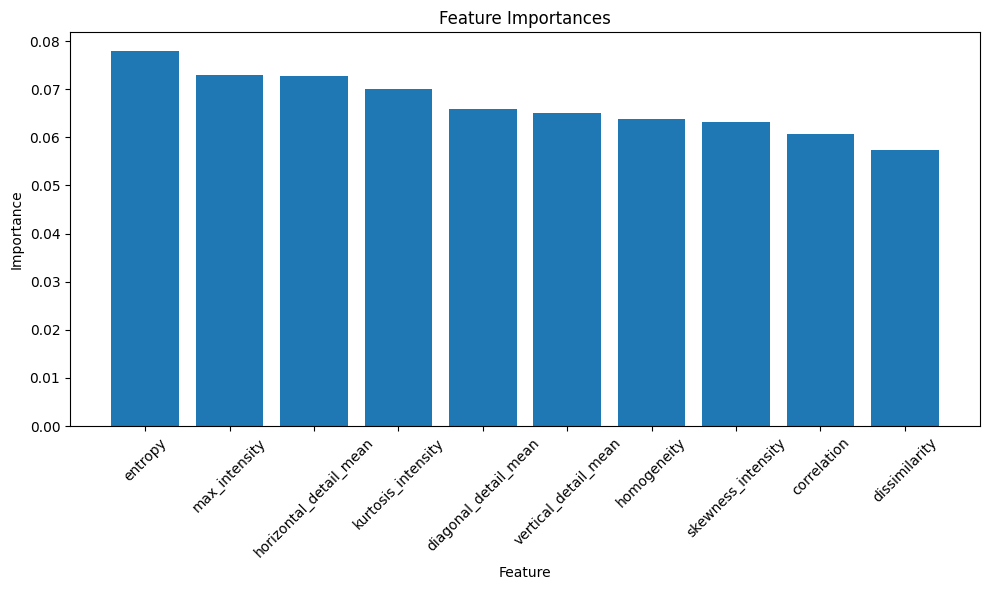

In [115]:


plot_feature_importances(rf_optimizer.best_model, np.array(X_train_fs.columns))


<Axes: >

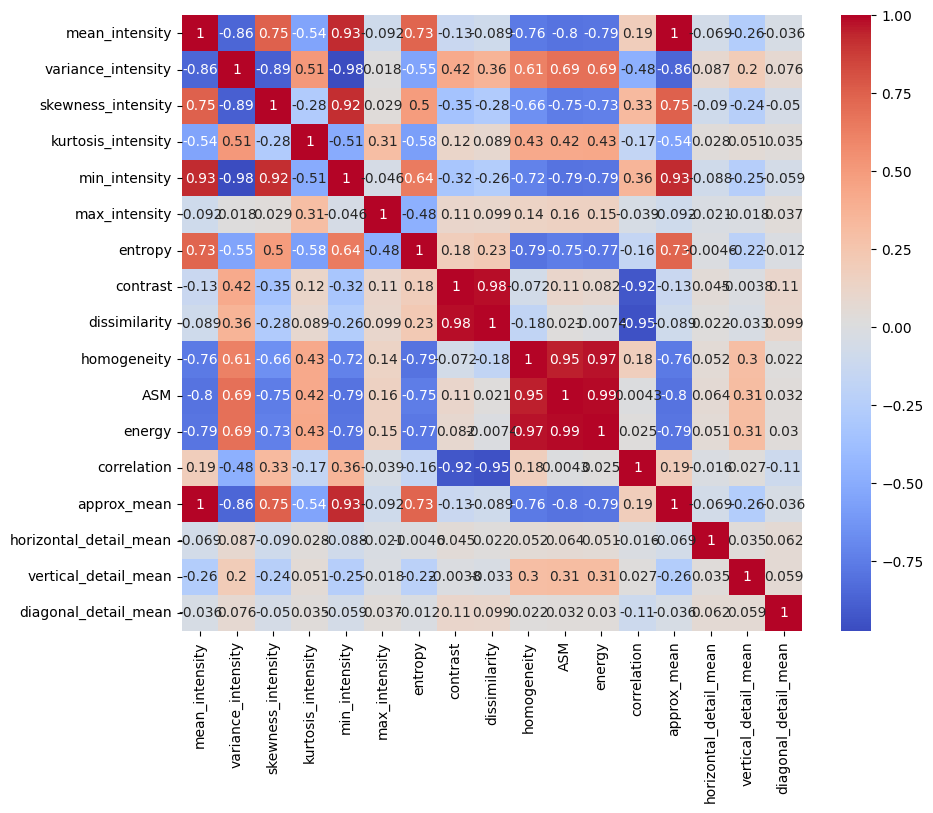

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_fs.corr(), annot=True, cmap="coolwarm")


The accuracy with the use of Random Forest with Grid Search is 44%. Since this performance does not achieve a satisfactory level of accuracy for our dataset, we will transition to applying a deep learning model to potentially improve the classification performance. Specifically, we will implement a Convolutional Neural Network (CNN) as our next step, leveraging its capability to capture complex spatial and textural features from the images.

# 4. Classification Task Nodule



*   Baseline Models: Logistic Regression and Decision Tree
*   Advanced Models: SVM and Random Forest
*   Deep Learning: CNN



### Baseline Models

#### **Logistic Regression**

Compute the real class weights to take them into account

In [ ]:
from sklearn.ensemble import RandomForestClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report
from bayes_opt import BayesianOptimization
from collections import Counter


In [35]:

class_counts = Counter(y_train_nod)
total_samples = len(y_train_nod)

class_weight = {cls: total_samples / count for cls, count in class_counts.items()}

print("Class Weights:", class_weight)

Class Weights: {4: 5.658682634730539, 3: 2.1649484536082473, 1: 9.692307692307692, 2: 5.163934426229508, 5: 15.491803278688524}


In [36]:


# Train the model
logreg = LogisticRegression(max_iter=1000, random_state=SEED, class_weight=class_weight)
logreg.fit(X_train_nod, y_train_nod)

# Evaluate the model
y_pred = logreg.predict(X_test_nod)
print("f1_score:", f1_score(y_test_nod, y_pred))
print("Classification Report:\n", classification_report(y_test_nod, y_pred))


Accuracy: 0.3361522198731501
Classification Report:
               precision    recall  f1-score   support

           1       0.32      0.49      0.39        49
           2       0.25      0.29      0.27        91
           3       0.58      0.34      0.43       219
           4       0.28      0.24      0.26        84
           5       0.14      0.47      0.22        30

    accuracy                           0.34       473
   macro avg       0.32      0.36      0.31       473
weighted avg       0.41      0.34      0.35       473



/home/malvin/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression is perfoming ok for this dataset, with just a 33% of accuracy.

#### **Decision Tree**

In [37]:

# Train the model
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train_nod, y_train_nod)

# Evaluate the model
y_pred = tree.predict(X_test_nod)
print("f1_score:", f1_score(y_test_nod, y_pred))
print("Classification Report:\n", classification_report(y_test_nod, y_pred))


Accuracy: 0.33403805496828753
Classification Report:
               precision    recall  f1-score   support

           1       0.33      0.35      0.34        49
           2       0.18      0.16      0.17        91
           3       0.48      0.43      0.46       219
           4       0.23      0.27      0.25        84
           5       0.19      0.27      0.22        30

    accuracy                           0.33       473
   macro avg       0.28      0.30      0.29       473
weighted avg       0.35      0.33      0.34       473



We can observe that the Decision Tree performs slightly better than Logistic Regression, achieving 37% accuracy.
Based on this, we conclude that baseline models are insufficient for our dataset.
Therefore, we will proceed to train advanced models to address these challenges and improve performance.

### Advanced Models

#### **SVM**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Entrenar SVM con kernel lineal
svm = SVC(kernel='linear', class_weight=class_weight, random_state=SEED)
svm.fit(X_train_nod, y_train_nod)

# Evaluar el modelo
y_pred = svm.predict(X_test_nod)
print("SVM f1_score:", f1_score(y_test_nod, y_pred))
print("SVM Classification Report:\n", classification_report(y_test_nod, y_pred))


The SVM model yielded a very low accuracy of 22%, indicating that it may not be well-suited for this dataset. As a result, we will proceed to evaluate the Random Forest model to determine if it provides better performance.

#### **Random Forest**

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar Random Forest
rf = RandomForestClassifier(random_state=SEED, class_weight=class_weight)
rf.fit(X_train_nod, y_train_nod)

# Evaluar el modelo
y_pred = rf.predict(X_test_nod)
print("Random Forest f1-score:", f1_score(y_test_nod, y_pred, average='weighted'))
print("Random Forest Classification Report:\n", classification_report(y_test_nod, y_pred))


Random Forest f1-score: 0.4658923816076879
Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.33      0.44        49
           2       0.14      0.01      0.02        91
           3       0.56      0.92      0.70       219
           4       0.45      0.35      0.39        84
           5       0.53      0.30      0.38        30

    accuracy                           0.54       473
   macro avg       0.47      0.38      0.39       473
weighted avg       0.47      0.54      0.47       473



The Random Forest model achieved an accuracy of 52%. To further enhance its performance, we will apply cross-validation combined with Grid Search for hyperparameter tuning to identify the optimal combination of parameters, aiming to improve the model's accuracy.

In [26]:
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=SEED,
        class_weight=class_weight
    )

    f1 = cross_val_score(
        model, X_train_nod, y_train_nod, cv=5, scoring=make_scorer(f1_score, average='weighted')
    ).mean()

    return f1

pbounds = {
    'n_estimators': (50, 300),
    'max_depth': (5, 30),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}

optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=pbounds,
    random_state=SEED
)

# Optimization
optimizer.maximize(init_points=10, n_iter=30)

# Extract the best parameters
best_params = optimizer.max['params']
print("Best Parameters:", best_params)

# Round the parameters for the final model
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

# Final model with the best hyperparameters
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=SEED,
    class_weight=class_weight
)

best_rf.fit(X_train_nod, y_train_nod)
y_pred = best_rf.predict(X_test_nod)

# Final evaluation
print("Tuned Random Forest Accuracy:", accuracy_score(y_test_nod, y_pred))
print("Tuned Random Forest F1-Score:", f1_score(y_test_nod, y_pred, average='weighted'))
print("Tuned Random Forest Classification Report:\n", classification_report(y_test_nod, y_pred))


|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.3617    | 14.36     | 9.556     | 15.18     | 199.7     |
| 2         | 0.3812    | 8.9       | 2.404     | 3.046     | 266.5     |
| 3         | 0.3848    | 20.03     | 7.373     | 2.371     | 292.5     |
| 4         | 0.3984    | 25.81     | 2.911     | 5.273     | 95.85     |
| 5         | 0.3855    | 12.61     | 5.723     | 9.775     | 122.8     |
| 6         | 0.3873    | 20.3      | 2.255     | 7.259     | 141.6     |
| 7         | 0.3778    | 16.4      | 8.067     | 5.594     | 178.6     |
| 8         | 0.3738    | 19.81     | 1.418     | 12.94     | 92.63     |
| 9         | 0.3217    | 6.626     | 9.54      | 19.38     | 252.1     |
| 10        | 0.3891    | 12.62     | 1.879     | 14.32     | 160.0     |
| 11        | 0.3677    | 23.08     | 7.013     | 6.011     | 65.97     |
| 12        | 0.3294    | 6.23      | 

#### **Crossvalidate model to obtain the best fit**

In [92]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=SEED, class_weight=class_weight),
                           param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_nod, y_train_nod)

print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate the tuned Random Forest
y_pred = best_rf.predict(X_test_nod)
print("Tuned Random Forest f1-score:", accuracy_score(y_test_nod, y_pred))
print("Tuned Random Forest Classification Report:\n", classification_report(y_test_nod, y_pred))


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Tuned Random Forest f1-score: 0.5581395348837209
Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.59      0.41      0.48        49
           2       0.47      0.09      0.15        91
           3       0.57      0.85      0.68       219
           4       0.51      0.43      0.46        84
           5       0.54      0.47      0.50        30

    accuracy                           0.56       473
   macro avg       0.54      0.45      0.46       473
weighted avg       0.54      0.56      0.51       473



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Best parameters from optimization
best_params = {
    'n_estimators': 155,
    'max_depth': 30,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True
}

# Create the Random Forest model with the best parameters
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)

# Train the model on the training data
best_rf.fit(X_train_nod, y_train_nod)

# Make predictions on the test data
y_pred = best_rf.predict(X_test_nod)

# Evaluate the model
f1_score = f1_score(y_test_nod, y_pred)
print("Random Forest f1_score:", f1_score)
print("Classification Report:\n", classification_report(y_test_nod, y_pred))

Random Forest Accuracy: 0.4989429175475687
Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.35      0.46        49
           2       0.40      0.02      0.04        91
           3       0.50      0.92      0.65       219
           4       0.32      0.14      0.20        84
           5       0.67      0.13      0.22        30

    accuracy                           0.50       473
   macro avg       0.51      0.31      0.31       473
weighted avg       0.48      0.50      0.41       473



#### Improve Random Forest :

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np




X_temp_nod, X_unseen_nod, y_temp_nod, y_unseen_nod = train_test_split(
    X_full_nodule, y_full_nodule, 
    test_size=0.1, # 10% for unseen
    stratify=y_full_nodule, 
    random_state=SEED
)



imputer = KNNImputer(n_neighbors=5)

X_temp_nod_imputed = pd.DataFrame(imputer.fit_transform(X_temp_nod), columns=X_temp_nod.columns)
X_unseen_nod_imputed = pd.DataFrame(imputer.transform(X_unseen_nod), columns=X_unseen_nod.columns)

X_train_nod, X_test_nod, y_train_nod, y_test_nod = train_test_split(
    X_temp_nod_imputed, y_temp_nod,
    test_size=0.2,
    stratify=y_temp_nod,
    random_state=SEED
)

[I 2025-01-11 14:53:11,421] A new study created in memory with name: no-name-7ad46c4b-855f-4f0f-b1f2-1d12cc6a919e



Starting hyperparameter optimization...
Number of features: 31
Number of samples: 1700
Number of classes: 5

Class distribution:
Class 1: 176
Class 2: 329
Class 3: 785
Class 4: 301
Class 5: 109


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-01-11 14:53:17,630] Trial 0 finished with value: 0.4279729702797178 and parameters: {'n_estimators': 410, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.4279729702797178.
[I 2025-01-11 14:53:23,630] Trial 1 finished with value: 0.43779702940228543 and parameters: {'n_estimators': 433, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.43779702940228543.
[I 2025-01-11 14:53:26,332] Trial 2 finished with value: 0.42932363968268084 and parameters: {'n_estimators': 160, 'max_depth': 23, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.43779702940228543.
[I 2025-01-11 14:53:32,879] Trial 3 finished with value: 0.4429505980762369 and parameters: {'n_estimators': 383, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 9, 'ma

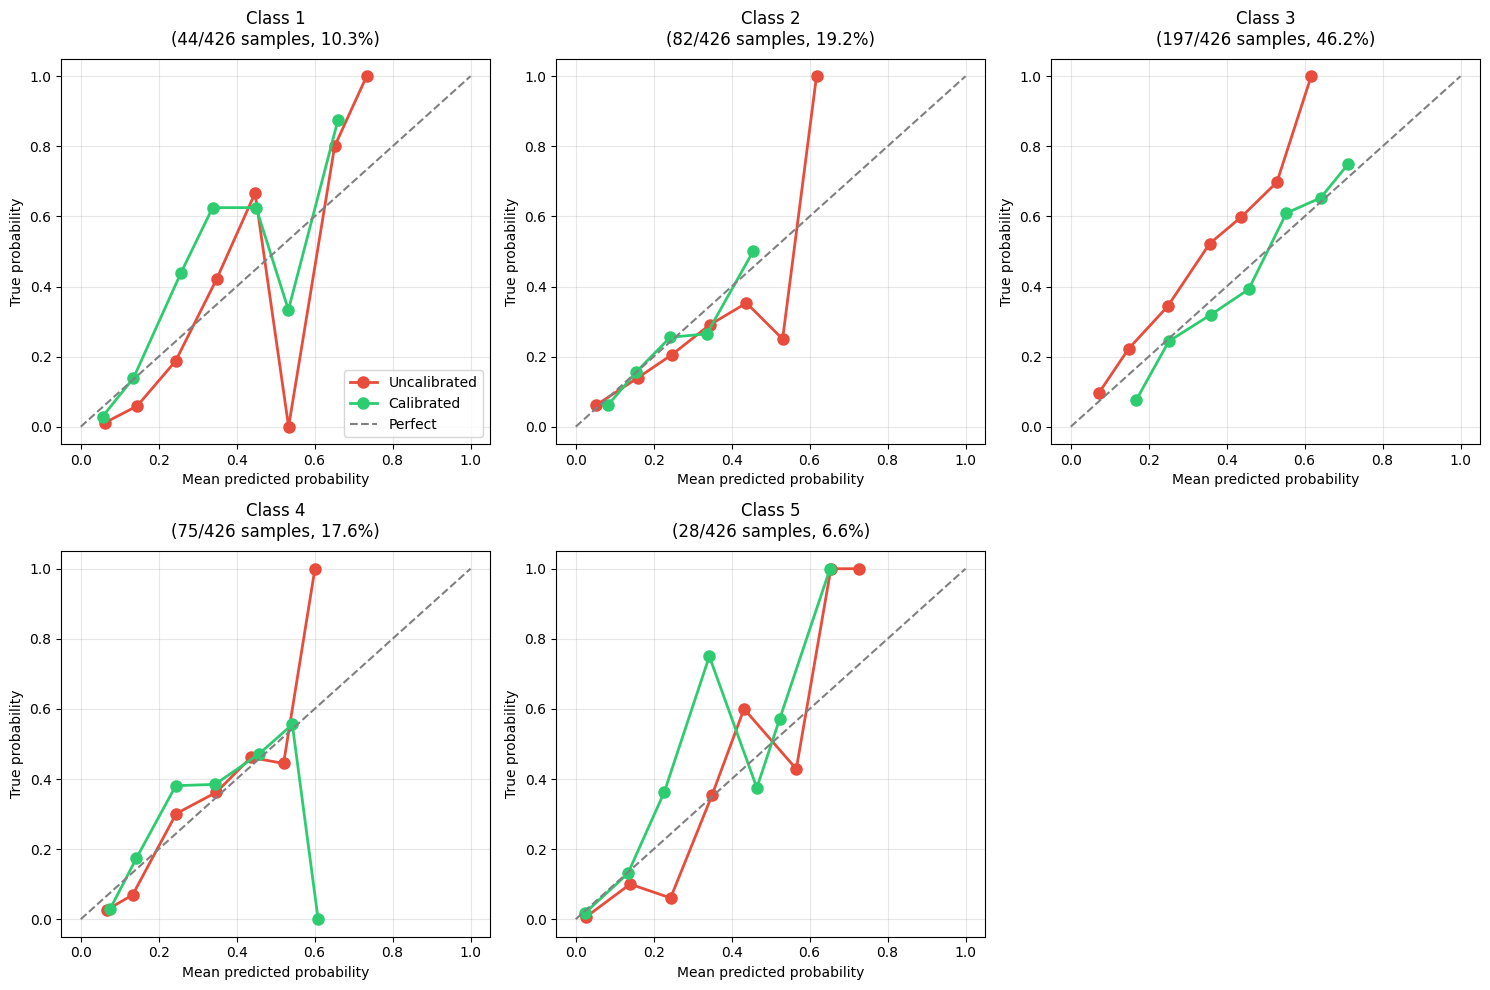

No predictions met the confidence threshold of 0.8
No predictions met the confidence threshold of 0.8

Training the model on the full dataset...
Training on the full dataset is complete.
Model saved to: rf_nodule_multiclass.joblib


In [25]:

rf_optimizer = RandomForestOptimizer(
    X_train_nod, y_train_nod,
    X_test_nod, y_test_nod,
    X_unseen_nod_imputed, y_unseen_nod
)

rf_optimizer.optimize(n_trials=100)

rf_optimizer.calibrate_probabilities()

rf_optimizer.plot_calibration_curves()

test_results = rf_optimizer.evaluate_with_confidence(confidence_threshold=0.8, dataset="test")

unseen_results = rf_optimizer.evaluate_with_confidence(confidence_threshold=0.8, dataset="unseen")

rf_optimizer.train_on_full_dataset()

rf_optimizer.save_model('rf_nodule_multiclass.joblib')

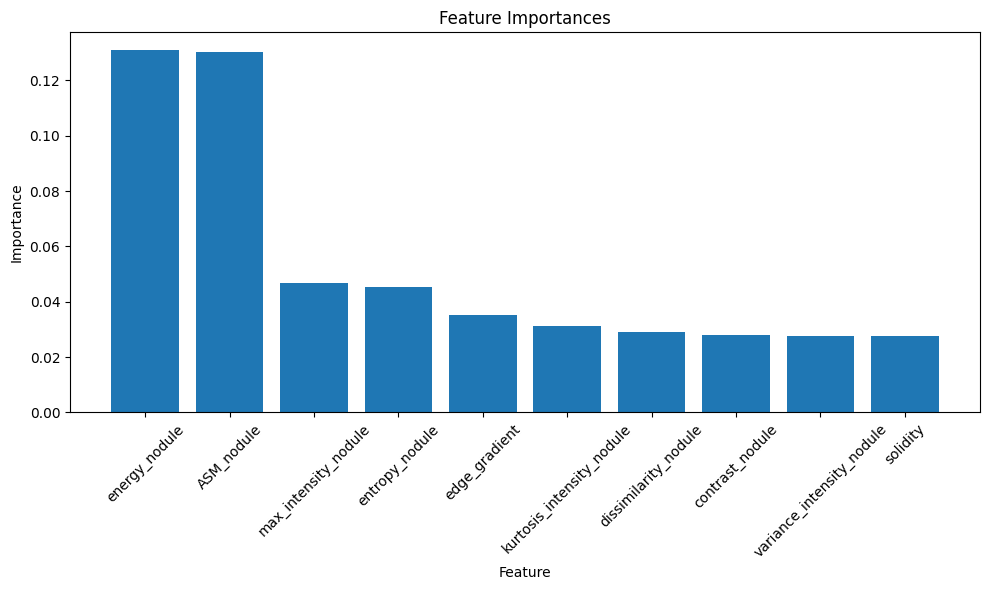

In [118]:
import matplotlib.pyplot as plt
import numpy as np

plot_feature_importances(rf_optimizer.best_model, np.array(X_train_nod.columns))



<Axes: >

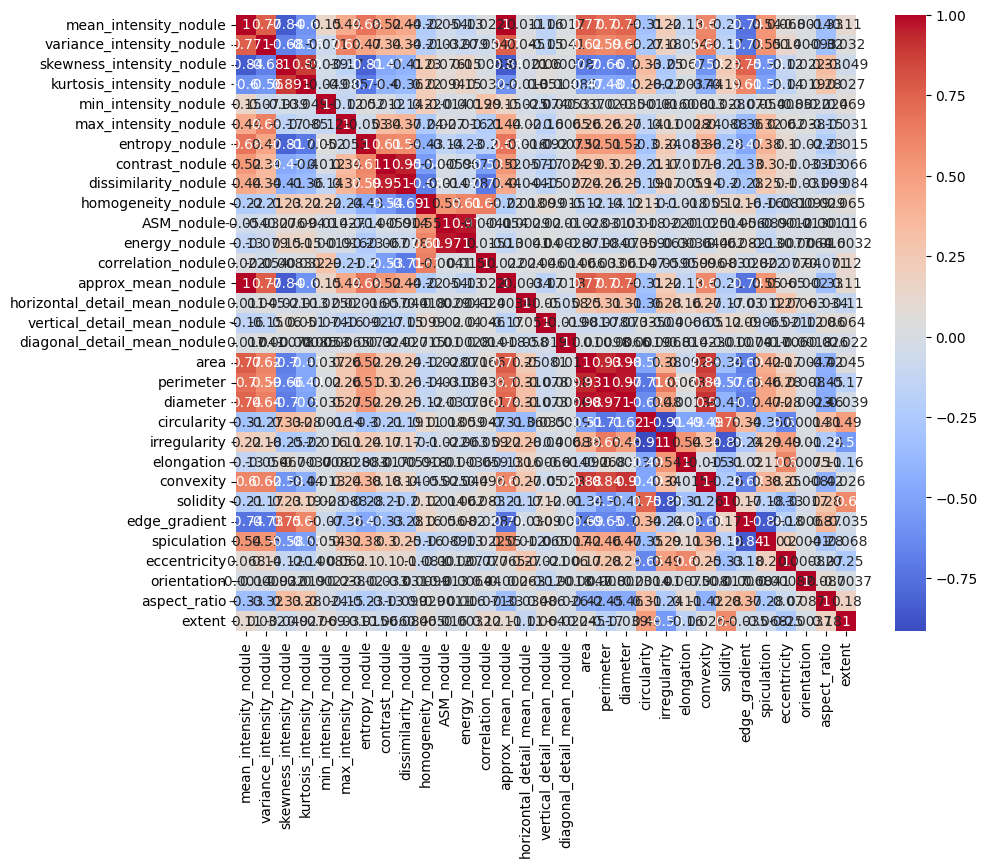

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_nod.corr(), annot=True, cmap="coolwarm")


The f1-score with the use of Random Forest with Grid Search is 31%. Since this performance does not achieve a satisfactory level of performance for our dataset, we will transition to applying a deep learning model to potentially improve the classification performance.

### Deep Learning

#### A) Preprocess the Datase

In [30]:
#We need to modify the data split done on Feature preparation
# Use full_slices (image data) for CNN instead of tabular data
from sklearn.model_selection import train_test_split

# First Split: Training (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    full_slices, tumor_classes, test_size=0.4, stratify=tumor_classes, random_state=42
)

# Second Split: Validation (20%) and Test (20%) from Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# We add a channel dimension to the image only if it is missing
if X_train.ndim == 3:  
    X_train = np.expand_dims(X_train, axis=-1)  # New shape: (num_samples, height, width, channels)

if X_val.ndim == 3:  
    X_val = np.expand_dims(X_val, axis=-1)  

if X_test.ndim == 3:
    X_test = np.expand_dims(X_test, axis=-1) 

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


Training set size: 1417
Validation set size: 473
Test set size: 473
X_train shape: (1417, 128, 128, 1)
X_val shape: (473, 128, 128, 1)


In [31]:
# Subtract 1 from all labels to map the range [1, 5] to [0, 4]
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

y_train = y_train - y_train.min()  # Ensure the minimum is 0
y_val = y_val - y_val.min()
y_test = y_test - y_test.min()

# Verify the new range of labels
print(f"y_train range: {y_train.min()} to {y_train.max()}")
print(f"y_val range: {y_val.min()} to {y_val.max()}")
print(f"y_test range: {y_test.min()} to {y_test.max()}")

y_train range: 0 to 4
y_val range: 0 to 4
y_test range: 0 to 4


In [32]:
import tensorflow as tf
def preprocess_image(image, label):
    # Convert grayscale (1 channel) to RGB (3 channels)
    image = tf.image.grayscale_to_rgb(image) if image.shape[-1] == 1 else image
    image = tf.image.resize(image, (224, 224))  # Resize to match CNN input
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (train_ds
            .shuffle(1000)
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE))

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = (val_ds
          .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(32)
          .prefetch(tf.data.AUTOTUNE))

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = (test_ds
           .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(32)
           .prefetch(tf.data.AUTOTUNE))


#### B) Train and Evaluate Models

#### **CNN**  

In [38]:
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Prepare augmented training dataset
augmented_train_ds = datagen.flow(X_train, y_train, batch_size=32)

# Define the improved CNN model
model = Sequential([
    layers.Input(shape=(224, 224, 3)),  # Explicitly define the input layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # Adjust for 5-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks for early stopping and learning rate reduction
callback_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint(
        filepath='cnn_best_model.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )
]


In [128]:

# Train the improved CNN model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1,
)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4611 - loss: 1.9549 - val_accuracy: 0.4630 - val_loss: 2.0705
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4714 - loss: 1.9938 - val_accuracy: 0.4630 - val_loss: 1.7923
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4566 - loss: 1.7981 - val_accuracy: 0.4630 - val_loss: 1.9598
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4652 - loss: 1.9538 - val_accuracy: 0.4588 - val_loss: 1.9891
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4696 - loss: 2.0606 - val_accuracy: 0.4609 - val_loss: 3.0357
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4381 - loss: 2.7016 - val_accuracy: 0.4609 - val_loss: 3.6071
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4426 - loss: 4.4889 - val_accuracy: 0.4588 - val_loss: 5.9847
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4549 - loss: 5.6104 - val_accuracy: 0.4609 - v

In [129]:
#Evaluating CNN model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4565 - loss: 1.6459
Test Accuracy: 0.46088793873786926


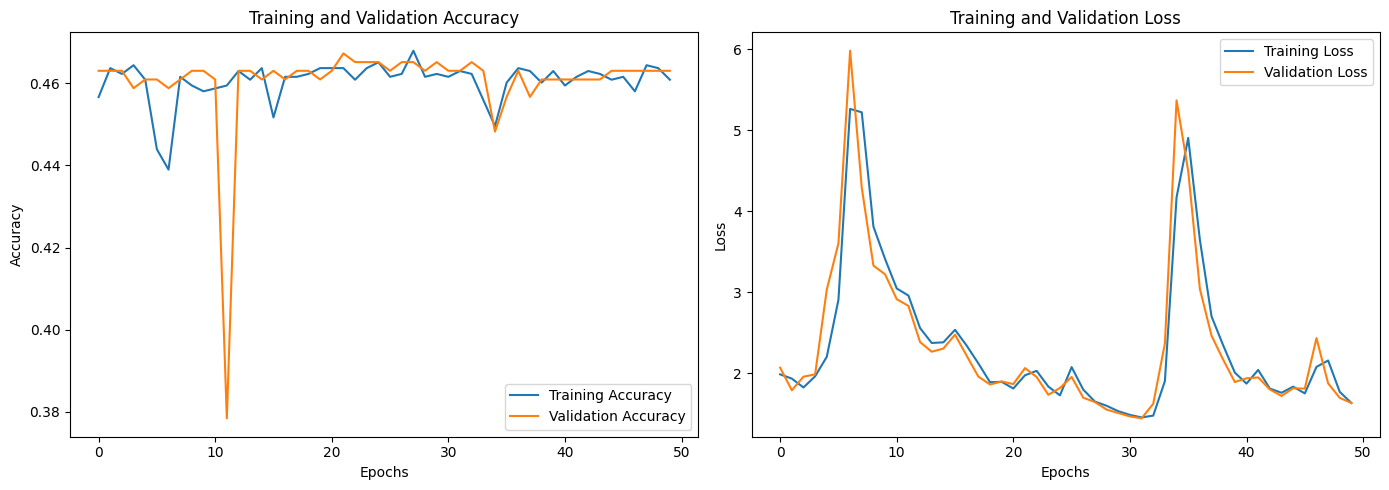

In [130]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training and Validation Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].legend()

# Plot Training and Validation Loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()


The CNN achieved an accuracy of 46%, as shown in the graphs. From the plots of training and validation accuracy and loss, we observe significant fluctuations in accuracy and high volatility in loss values, which could indicate issues such as overfitting, underfitting, or unstable training dynamics. Based on these results, we decided to explore other models like **EfficientNetB3**, **ResNet**, and **VGG**, which may capture the spatial and textural features of the dataset more effectively and potentially improve overall performance.

#### **EfficientNetB3 Model**

In [30]:

#Fine-tune EfficientNetB3 for improved performance

# Preprocessing Adjustments for EfficientNet
def preprocess_image_efficientnet(image, label):
    # Ensure images are resized to 300x300 for EfficientNet
    image = tf.image.grayscale_to_rgb(image) if image.shape[-1] == 1 else image
    image = tf.image.resize(image, (300, 300))  # Resize for EfficientNet
    image = image / 255.0  # Normalize pixel values
    return image, label

# Update datasets for EfficientNet
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (train_ds
            .shuffle(1000)
            .map(preprocess_image_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(32)
            .prefetch(tf.data.AUTOTUNE))

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = (val_ds
          .map(preprocess_image_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(32)
          .prefetch(tf.data.AUTOTUNE))

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = (test_ds
           .map(preprocess_image_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(32)
           .prefetch(tf.data.AUTOTUNE))

In [39]:
# Define and Fine-Tune EfficientNetB3
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models, regularizers, callbacks

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False  # Freeze pre-trained layers initially

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Increased units for better feature extraction
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5-class classification
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Unfreeze base model and fine-tune
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks for early stopping and learning rate adjustment
callback_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint(
        filepath='efficientnetb3_finetuned_best_model.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )
]

# Fine-tune the model
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # Increased epochs to allow for better fine-tuning
    verbose=1,
    callbacks=callback_list
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2422 - loss: 5.9987   
Epoch 1: val_loss improved from inf to 6.03813, saving model to efficientnetb3_finetuned_best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.2428 - loss: 5.9980 - val_accuracy: 0.0634 - val_loss: 6.0381 - learning_rate: 1.0000e-05
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.3520 - loss: 5.8645
Epoch 2: val_loss did not improve from 6.03813
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 524ms/step - accuracy: 0.3523 - loss: 5.8641 - val_accuracy: 0.0634 - val_loss: 6.0675 - learning_rate: 1.0000e-05
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.4285 - loss: 5.7752
Epoch 3: val_loss did not improve from 6.03813
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 561ms/step - accuracy: 0.4283 - loss: 5.7754 - val_accuracy: 0.0634 - val_loss: 6.0633 - learning_rate: 1.0000e-05
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - a

In [40]:
#Evaluate EfficientNetB3
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"EfficientNetB3 Test Accuracy: {test_accuracy:.2f}")

from sklearn.metrics import classification_report, f1_score

# Get predictions
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Classification report
print("EfficientNetB3 Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']))

# F1-score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"EfficientNetB3 Weighted F1-Score: {f1:.2f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.3695 - loss: 4.9209
EfficientNetB3 Test Accuracy: 0.38
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 686ms/step
EfficientNetB3 Classification Report:
              precision    recall  f1-score   support

     Class 1       0.41      0.18      0.25        49
     Class 2       0.18      0.16      0.17        91
     Class 3       0.48      0.58      0.53       218
     Class 4       0.27      0.30      0.29        84
     Class 5       0.25      0.13      0.17        31

    accuracy                           0.38       473
   macro avg       0.32      0.27      0.28       473
weighted avg       0.37      0.38      0.36       473

EfficientNetB3 Weighted F1-Score: 0.36


Based on the performance results of the EfficientNetB3 model, which achieved a test accuracy of 38% and a weighted F1-score of 0.36, we observe that the model struggles to generalize effectively across all classes. This is evident from the low recall and precision scores for most classes, indicating an imbalance in its ability to accurately classify minority classes. Given these limitations, we will transition to trying the EfficientNetV2L model, which offers enhanced architecture and improved feature extraction capabilities. The aim is to leverage its more advanced design to better capture complex patterns in the dataset and improve overall classification performance.

####  **EfficientNetV2L**

In [33]:
import numpy as np
import cv2
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise
from tensorflow.keras.applications import EfficientNetV2L
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime as tim

In [34]:
# Data Augmentation for Underrepresented Classes
print("Applying data augmentation...")
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_X, augmented_y = [], []
for img, label in zip(X_train, y_train):
    if label in [2, 4]:  # Underrepresented classes
        for _ in range(5):  # Generate multiple augmentations per image
            augmented_X.append(datagen.random_transform(img))
            augmented_y.append(label)

# Concatenate original and augmented data
X_train = np.concatenate([X_train, np.array(augmented_X)])
y_train = np.concatenate([y_train, np.array(augmented_y)])

# Compute Class Weights
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}
print("Class weights:", class_weights)

Applying data augmentation...
Class weights: {0: 7.050684931506849, 1: 3.756934306569343, 2: 0.26193384223918575, 3: 4.101195219123506, 4: 1.8853479853479853}


In [35]:
# Preprocess Images (Resize and Ensure 3 Channels)
def preprocess_images(images, target_size=(64, 64)):
    resized_images = np.array([cv2.resize(img, target_size) for img in images])
    if resized_images.ndim == 3:  # If grayscale, convert to RGB
        resized_images = np.repeat(resized_images[..., np.newaxis], 3, axis=-1)
    return resized_images

X_train_resized = preprocess_images(X_train)
X_val_resized = preprocess_images(X_val)
X_test_resized = preprocess_images(X_test)

# Convert Labels to One-Hot Encoding
num_classes = len(np.unique(y_train))
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
                               
# Define EfficientNetV2L Model
base_model = EfficientNetV2L(
    input_shape=(64, 64, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Step 5: Define EfficientNetV2L Model
print("Building EfficientNetV2L model...")
base_model = EfficientNetV2L(
    input_shape=(64, 64, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

inputs = Input(shape=(64, 64, 3))
x = GaussianNoise(stddev=0.1)(inputs)
x = base_model(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Focal Loss Function
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# Compile the Model
model.compile(
    loss=focal_loss(gamma=2.0, alpha=0.25),
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
# Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('efficientnetv2l_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
]


473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Building EfficientNetV2L model...


In [36]:
# Train the Model
print("Training the model...")
history = model.fit(
    X_train_resized, y_train_one_hot,
    validation_data=(X_val_resized, y_val_one_hot),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks
)

Training the model...
Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 685s 4s/step - accuracy: 0.2845 - loss: 0.2534 - val_accuracy: 0.1501 - val_loss: 0.5953 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.3386 - loss: 0.1896 - val_accuracy: 0.1078 - val_loss: 0.4016 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 495s 3s/step - accuracy: 0.3737 - loss: 0.1767 - val_accuracy: 0.1268 - val_loss: 0.4358 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.4042 - loss: 0.1759 - val_accuracy: 0.1247 - val_loss: 0.4049 - learning_rate: 0.0010
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3668 - loss: 0.1811
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
161/161 ━━━━━━━━━━━━━━━━━━━━ 574s 4s/step - accuracy: 0.3667 - loss: 0.1811 - val_accuracy: 0.1099 - val_loss: 0.4124 - learning_rate: 0.0010
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 559s 3s/step - accuracy

In [37]:
#Evaluate EfficientNetV2L

test_loss, test_accuracy = model.evaluate(X_test_resized, to_categorical(y_test, num_classes=num_classes))
print(f"EfficientNetV2L Test Accuracy: {test_accuracy:.2f}")

# Generate Classification Report
y_pred = model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
print("EfficientNetV2L Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=[f'Class {i+1}' for i in range(num_classes)], zero_division=1))

# F1-score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"EfficientNetV2L Weighted F1-Score: {f1:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 414ms/step - accuracy: 0.1511 - loss: 0.6441
EfficientNetV2L Test Accuracy: 0.15
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 776ms/step
EfficientNetV2L Classification Report:
              precision    recall  f1-score   support

     Class 1       0.13      0.47      0.20        49
     Class 2       0.14      0.01      0.02        91
     Class 3       1.00      0.00      0.00       218
     Class 4       0.19      0.43      0.26        84
     Class 5       0.13      0.42      0.20        31

    accuracy                           0.15       473
   macro avg       0.32      0.27      0.14       473
weighted avg       0.54      0.15      0.08       473

EfficientNetV2L Weighted F1-Score: 0.08


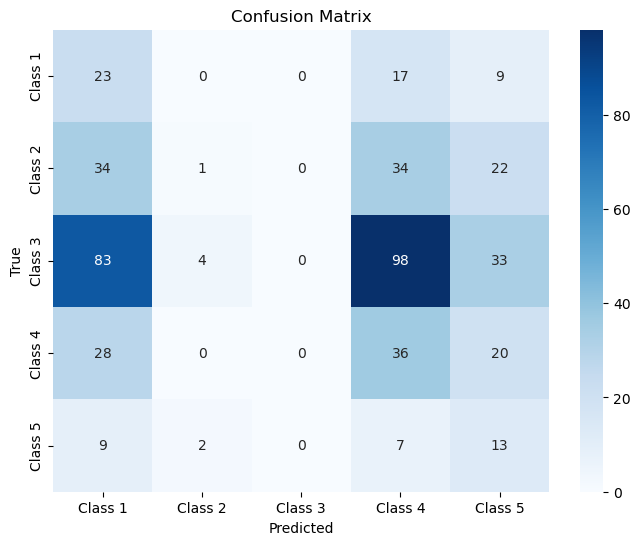

In [38]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i+1}' for i in range(num_classes)], yticklabels=[f'Class {i+1}' for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### **ResNet**

In [40]:
#Class balancing
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Increase weights for classes with poor performance
class_weights_dict = dict(enumerate(class_weights * 1.5))  # Adjust multiplier if needed


In [41]:
# Preprocessing Adjustments for ResNet
def preprocess_image_resnet(image, label):
    # Convert grayscale to RGB if necessary
    image = tf.image.grayscale_to_rgb(image) if image.shape[-1] == 1 else image
    # Resize for ResNet
    image = tf.image.resize(image, (224, 224))
    # Normalize pixel values
    image = image / 255.0
    return image, label

# Apply preprocessing to datasets
train_ds_resnet = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds_resnet = (train_ds_resnet
                   .shuffle(1000)
                   .map(preprocess_image_resnet, num_parallel_calls=tf.data.AUTOTUNE)
                   .batch(32)
                   .prefetch(tf.data.AUTOTUNE))

val_ds_resnet = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds_resnet = (val_ds_resnet
                 .map(preprocess_image_resnet, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))

test_ds_resnet = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds_resnet = (test_ds_resnet
                  .map(preprocess_image_resnet, num_parallel_calls=tf.data.AUTOTUNE)
                  .batch(32)
                  .prefetch(tf.data.AUTOTUNE))


In [48]:
# Define ResNet50 Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # Adjust for 5-class classification
])

# Compile the model

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=20,
    verbose=1,
    class_weight=class_weights_dict
)


Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.2016 - loss: 3.8427 - val_accuracy: 0.4630 - val_loss: 1.8966
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.1427 - loss: 4.5091 - val_accuracy: 0.0634 - val_loss: 1.6019
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.1137 - loss: 3.8475 - val_accuracy: 0.4630 - val_loss: 1.6008
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.3005 - loss: 3.8253 - val_accuracy: 0.4630 - val_loss: 1.6006
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.2819 - loss: 3.8297 - val_accuracy: 0.4630 - val_loss: 1.6010
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.2463 - loss: 3.8023 - val_accuracy: 0.4630 - val_loss: 1.6012
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.2734 - loss: 3.8092 - val_accuracy: 0.4630 - val_loss: 1.6014
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.2678 - loss: 3.9018 - val_accu

In [49]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds_resnet)
print(f"ResNet50 Test Accuracy: {test_accuracy:.2f}")

# Get predictions
y_pred = model.predict(test_ds_resnet)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
from sklearn.metrics import classification_report, f1_score
print("ResNet50 Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']))

# F1-score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"ResNet50 Weighted F1-Score: {f1:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4565 - loss: 1.6028
ResNet50 Test Accuracy: 0.46
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
ResNet50 Classification Report:
              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00        49
     Class 2       0.00      0.00      0.00        91
     Class 3       0.46      1.00      0.63       218
     Class 4       0.00      0.00      0.00        84
     Class 5       0.00      0.00      0.00        31

    accuracy                           0.46       473
   macro avg       0.09      0.20      0.13       473
weighted avg       0.21      0.46      0.29       473

ResNet50 Weighted F1-Score: 0.29


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### **VGG**

In [50]:

#Preprocessing Adjustments for VGG
def preprocess_image_vgg(image, label):
    image = tf.image.grayscale_to_rgb(image) if image.shape[-1] == 1 else image
    image = tf.image.resize(image, (224, 224))  # Resize for VGG
    image = image / 255.0  # Normalize pixel values
    return image, label

In [51]:
# Define and Fine-Tune VGG
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # Adjust for 5-class classification
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

# Fine-tune VGG
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 251s 6s/step - accuracy: 0.3210 - loss: 1.7086 - val_accuracy: 0.4630 - val_loss: 1.3862
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 257s 6s/step - accuracy: 0.4407 - loss: 1.4276 - val_accuracy: 0.4630 - val_loss: 1.3803
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 259s 6s/step - accuracy: 0.4674 - loss: 1.3937 - val_accuracy: 0.4630 - val_loss: 1.3815
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 265s 6s/step - accuracy: 0.4894 - loss: 1.3676 - val_accuracy: 0.4630 - val_loss: 1.3836
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 255s 6s/step - accuracy: 0.4745 - loss: 1.3591 - val_accuracy: 0.4630 - val_loss: 1.3823
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 248s 6s/step - accuracy: 0.4402 - loss: 1.4099 - val_accuracy: 0.4630 - val_loss: 1.3875
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 265s 6s/step - accuracy: 0.4438 - loss: 1.3920 - val_accuracy: 0.4630 - val_loss: 1.3682
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 253s 6s/step - accuracy: 0.4458 - loss: 1.3765 - val_accuracy: 0.4630 - v

In [52]:
#Evaluate VGG
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"VGG Test Accuracy: {test_accuracy:.2f}")

# Get predictions
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("VGG Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']))

# F1-score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"VGG Weighted F1-Score: {f1:.2f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - accuracy: 0.4329 - loss: 1.4218
VGG Test Accuracy: 0.45
15/15 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step
VGG Classification Report:
              precision    recall  f1-score   support

     Class 1       0.44      0.08      0.14        49
     Class 2       0.25      0.09      0.13        91
     Class 3       0.47      0.93      0.62       218
     Class 4       0.00      0.00      0.00        84
     Class 5       0.00      0.00      0.00        31

    accuracy                           0.45       473
   macro avg       0.23      0.22      0.18       473
weighted avg       0.31      0.45      0.33       473

VGG Weighted F1-Score: 0.33


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
#@title Compare Performance
import pandas as pd

results = {
    "Model": ["EfficientNetB3", "ResNet", "VGG"],
    "Test Accuracy": [effnet_accuracy, resnet_accuracy, vgg_accuracy],
    "Weighted F1-Score": [effnet_f1, resnet_f1, vgg_f1]
}

df_results = pd.DataFrame(results)
print(df_results)


NameError: name 'effnet_accuracy' is not defined

# 5. Binary Classification Task Full Slice 

The aim here is to reused the best classification model for the binary classification.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np

# Set random seed for reproducibility
SEED = 42

# Load the Extracted Features
df_full_slice = pd.read_csv('dataset_lung_features_full_slice.csv')
df_full_nodule = pd.read_csv('dataset_lung_features_nodule_extended.csv')
df_all = pd.read_csv('dataset_lung_features_all.csv')

# Separate Features and Labels
X_full_slice_binary = df_full_slice.drop(columns=['Full_slice', 'Nodule', 'TumorClass','Malignancy'])  # Features
y_full_slice_binary = df_full_slice['Malignancy']  # Labels

X_full_nodule_binary = df_full_nodule.drop(columns=['Full_slice', 'Nodule', 'TumorClass','Malignancy'])  # Features
y_full_nodule_binary = df_full_nodule['Malignancy']  # Labels

# First split: separate unseen data
X_temp_fs_binary, X_unseen_fs_binary, y_temp_fs_binary, y_unseen_fs_binary = train_test_split(
    X_full_slice_binary, 
    y_full_slice_binary,
    test_size=0.1,  # 10% for unseen data
    stratify=y_full_slice_binary,
    random_state=SEED
)

X_temp_nod_binary, X_unseen_nod_binary, y_temp_nod_binary, y_unseen_nod_binary = train_test_split(
    X_full_nodule_binary,
    y_full_nodule_binary,
    test_size=0.1,
    stratify=y_full_nodule_binary,
    random_state=SEED
)

# Second split: divide remaining data into train and test
X_train_fs_binary, X_test_fs_binary, y_train_fs_binary, y_test_fs_binary = train_test_split(
    X_temp_fs_binary,
    y_temp_fs_binary,
    test_size=0.2,
    stratify=y_temp_fs_binary,
    random_state=SEED
)

X_train_nod_binary, X_test_nod_binary, y_train_nod_binary, y_test_nod_binary = train_test_split(
    X_temp_nod_binary,
    y_temp_nod_binary,
    test_size=0.2,
    stratify=y_temp_nod_binary,
    random_state=SEED
)

# Apply KNN Imputer to handle NaN values
imputer = KNNImputer(n_neighbors=5)

# Fit imputer on training data only and transform all sets
X_train_fs_binary = pd.DataFrame(imputer.fit_transform(X_train_fs_binary), columns=X_train_fs_binary.columns)
X_test_fs_binary = pd.DataFrame(imputer.transform(X_test_fs_binary), columns=X_test_fs_binary.columns)
X_unseen_fs_binary = pd.DataFrame(imputer.transform(X_unseen_fs_binary), columns=X_unseen_fs_binary.columns)

X_train_nod_binary = pd.DataFrame(imputer.fit_transform(X_train_nod_binary), columns=X_train_nod_binary.columns)
X_test_nod_binary = pd.DataFrame(imputer.transform(X_test_nod_binary), columns=X_test_nod_binary.columns)
X_unseen_nod_binary = pd.DataFrame(imputer.transform(X_unseen_nod_binary), columns=X_unseen_nod_binary.columns)

# Verify no NaN values remain
print("\nNaN values check:")
print("Full Slice Binary:")
print(f"Train: {X_train_fs_binary.isnull().sum().sum()}")
print(f"Test: {X_test_fs_binary.isnull().sum().sum()}")
print(f"Unseen: {X_unseen_fs_binary.isnull().sum().sum()}")

print("\nNodule Binary:")
print(f"Train: {X_train_nod_binary.isnull().sum().sum()}")
print(f"Test: {X_test_nod_binary.isnull().sum().sum()}")
print(f"Unseen: {X_unseen_nod_binary.isnull().sum().sum()}")

# Print dataset shapes
print("\nDataset shapes:")
print("Full Slice Binary:")
print(f"Train: {X_train_fs_binary.shape}")
print(f"Test: {X_test_fs_binary.shape}")
print(f"Unseen: {X_unseen_fs_binary.shape}")

print("\nNodule Binary:")
print(f"Train: {X_train_nod_binary.shape}")
print(f"Test: {X_test_nod_binary.shape}")
print(f"Unseen: {X_unseen_nod_binary.shape}")

# Print class distribution
print("\nClass distribution:")
print("Full Slice Binary:")
print(f"Train: {np.bincount(y_train_fs_binary)}")
print(f"Test: {np.bincount(y_test_fs_binary)}")
print(f"Unseen: {np.bincount(y_unseen_fs_binary)}")

print("\nNodule Binary:")
print(f"Train: {np.bincount(y_train_nod_binary)}")
print(f"Test: {np.bincount(y_test_nod_binary)}")
print(f"Unseen: {np.bincount(y_unseen_nod_binary)}")


NaN values check:
Full Slice Binary:
Train: 0
Test: 0
Unseen: 0

Nodule Binary:
Train: 0
Test: 0
Unseen: 0

Dataset shapes:
Full Slice Binary:
Train: (1700, 17)
Test: (426, 17)
Unseen: (237, 17)

Nodule Binary:
Train: (1700, 31)
Test: (426, 31)
Unseen: (237, 31)

Class distribution:
Full Slice Binary:
Train: [1290  410]
Test: [323 103]
Unseen: [180  57]

Nodule Binary:
Train: [1290  410]
Test: [323 103]
Unseen: [180  57]


## RandomForest :

[I 2025-01-11 15:12:35,771] A new study created in memory with name: no-name-f8fdff07-4e1a-4617-8040-d2f17a5d01ee


Starting hyperparameter optimization...
Number of features: 17
Number of samples: 1700
Class distribution: [1290  410]


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-01-11 15:12:38,279] Trial 0 finished with value: 0.679221499793903 and parameters: {'n_estimators': 147, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.679221499793903.
[I 2025-01-11 15:12:42,333] Trial 1 finished with value: 0.6777789044854645 and parameters: {'n_estimators': 311, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.679221499793903.
[I 2025-01-11 15:12:47,771] Trial 2 finished with value: 0.690399973715431 and parameters: {'n_estimators': 438, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.690399973715431.
[I 2025-01-11 15:12:50,796] Trial 3 finished with value: 0.693815171074174 and parameters: {'n_estimators': 233, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 

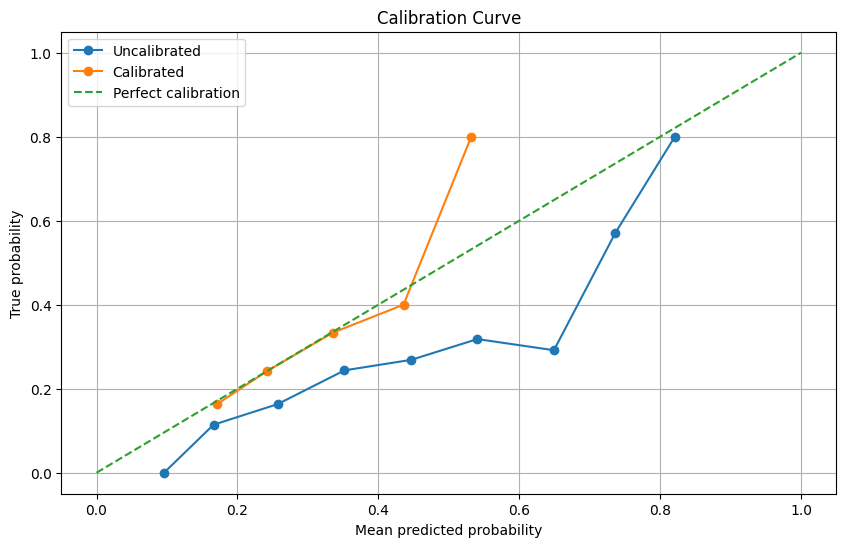


Confidence Threshold Analysis (threshold = 0.8):
Coverage: 34.51% of samples
High-confidence Accuracy: 0.8367
High-confidence F1-Score: 0.7624

Training the model with the best parameters on the full dataset...
Training on the full dataset is complete.
Model saved to: rf_fullslice_binary.joblib


In [28]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report
import numpy as np
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.utils.class_weight import compute_class_weight
import warnings
import joblib
from datetime import datetime
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report
import numpy as np
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.utils.class_weight import compute_class_weight
import warnings
import joblib
from datetime import datetime



class RandomForestOptimizer:
    def __init__(self, X_train, y_train, X_test, y_test, X_unseen=None, y_unseen=None, random_state=42):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_unseen = X_unseen
        self.y_unseen = y_unseen
        self.random_state = random_state
        self.best_model = None
        self.study = None
        self.calibrated_model = None
        self.class_weight = 'balanced'

    def objective(self, trial):
        """Objective function for Optuna optimization"""
        
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': self.class_weight,
            'random_state': self.random_state,
            'n_jobs': -1  # Use all available cores
        }
        
        # Create model with current parameters
        model = RandomForestClassifier(**params)
        
        # Perform stratified k-fold cross validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        try:
            # Calculate multiple metrics
            f1_scores = cross_val_score(
                model, self.X_train, self.y_train, 
                scoring=make_scorer(f1_score, average='weighted'),
                cv=cv
            )
            
            # Return mean F1 score
            return np.mean(f1_scores)
            
        except Exception as e:
            print(f"Error during cross validation: {str(e)}")
            return float('-inf')

    def optimize(self, n_trials=100):
        """Run the optimization process"""
        print("Starting hyperparameter optimization...")
        print(f"Number of features: {self.X_train.shape[1]}")
        print(f"Number of samples: {self.X_train.shape[0]}")
        print(f"Class distribution: {np.bincount(self.y_train)}")
        
        # Create study
        study = optuna.create_study(direction='maximize')
        
        # Optimize
        try:
            study.optimize(self.objective, n_trials=n_trials, show_progress_bar=True)
            self.study = study
            
            # Get best parameters
            best_params = study.best_params
            print("\nBest parameters:", best_params)
            print(f"Best F1-score: {study.best_value:.4f}")
            
            # Train final model with best parameters
            best_params['class_weight'] = self.class_weight
            best_params['random_state'] = self.random_state
            best_params['n_jobs'] = -1
            
            self.best_model = RandomForestClassifier(**best_params)
            self.best_model.fit(self.X_train, self.y_train)
            
        except Exception as e:
            print(f"Error during optimization: {str(e)}")
            raise
        
        return self
    
    def train_with_best_params(self):
        """Train a RandomForestClassifier on the full dataset using the best parameters"""
        if self.study is None:
            raise ValueError("Hyperparameter optimization hasn't been performed. Call optimize() first.")
        
        print("\nTraining the model with the best parameters on the full dataset...")
        
        # Get best parameters
        best_params = self.study.best_params
        best_params.update({
            'class_weight': self.class_weight,
            'random_state': self.random_state,
            'n_jobs': -1
        })
        
        # Combine datasets based on what's available
        datasets_X = [self.X_train, self.X_test]
        datasets_y = [self.y_train, self.y_test]
        
        if self.X_unseen is not None and self.y_unseen is not None:
            datasets_X.append(self.X_unseen)
            datasets_y.append(self.y_unseen)
        
        X_full = np.vstack(datasets_X)
        y_full = np.concatenate(datasets_y)
        
        # Train new model on full dataset
        self.best_model = RandomForestClassifier(**best_params)
        self.best_model.fit(X_full, y_full)
        
        print("Training on the full dataset is complete.")
        return self

    def calibrate_probabilities(self, cv=5):
        """Calibrate probability estimates using Platt Scaling"""
        if self.best_model is None:
            raise ValueError("Model hasn't been optimized yet. Call optimize() first.")
        
        print("Calibrating probability estimates...")
        self.calibrated_model = CalibratedClassifierCV(
            self.best_model, 
            cv=cv, 
            method='sigmoid',
            n_jobs=-1
        )
        self.calibrated_model.fit(self.X_train, self.y_train)
        
        # Calculate calibration metrics
        prob_pos_test = self.calibrated_model.predict_proba(self.X_test)[:, 1]
        brier = brier_score_loss(self.y_test, prob_pos_test)
        auc = roc_auc_score(self.y_test, prob_pos_test)
        
        print(f"\nCalibration Metrics:")
        print(f"Brier Score Loss: {brier:.4f} (lower is better)")
        print(f"ROC AUC Score: {auc:.4f}")
        
        return self
    
    def predict_with_confidence(self, X):
        """Make predictions with confidence estimates"""
        if self.calibrated_model is None:
            raise ValueError("Model hasn't been calibrated. Call calibrate_probabilities() first.")
        
        # Get calibrated probabilities
        probabilities = self.calibrated_model.predict_proba(X)
        
        # Get predictions and confidence scores
        predictions = np.argmax(probabilities, axis=1)
        confidences = np.max(probabilities, axis=1)
        
        return predictions, confidences, probabilities
    
    def evaluate_with_confidence(self, confidence_threshold=0.8):
        """Evaluate model performance considering confidence threshold"""
        if self.calibrated_model is None:
            raise ValueError("Model hasn't been calibrated. Call calibrate_probabilities() first.")
        
        # Get predictions and confidences
        y_pred, confidences, _ = self.predict_with_confidence(self.X_test)
        
        # Filter predictions based on confidence threshold
        high_confidence_mask = confidences >= confidence_threshold
        
        # Calculate metrics for high-confidence predictions
        if np.sum(high_confidence_mask) > 0:
            high_conf_accuracy = accuracy_score(
                self.y_test[high_confidence_mask], 
                y_pred[high_confidence_mask]
            )
            high_conf_f1 = f1_score(
                self.y_test[high_confidence_mask], 
                y_pred[high_confidence_mask], 
                average='weighted'
            )
            coverage = np.mean(high_confidence_mask)
            
            print(f"\nConfidence Threshold Analysis (threshold = {confidence_threshold}):")
            print(f"Coverage: {coverage:.2%} of samples")
            print(f"High-confidence Accuracy: {high_conf_accuracy:.4f}")
            print(f"High-confidence F1-Score: {high_conf_f1:.4f}")
            
            return {
                'coverage': coverage,
                'high_conf_accuracy': high_conf_accuracy,
                'high_conf_f1': high_conf_f1,
                'confidence_threshold': confidence_threshold
            }
        else:
            print(f"No predictions met the confidence threshold of {confidence_threshold}")
            return None

    def save_model(self, filepath):
        """Save the calibrated model to a file"""
        if self.calibrated_model is None:
            raise ValueError("No calibrated model to save. Run calibrate_probabilities() first.")
        
        # Save the calibrated model
        joblib.dump(self.calibrated_model, filepath)
        print(f"Model saved to: {filepath}")

    @staticmethod
    def load_model(filepath):
        """Load a saved model"""
        model = joblib.load(filepath)
        print(f"Model loaded from: {filepath}")
        return model

    def plot_calibration_curve(self):
        """Plot calibration curve to visualize probability calibration"""
        if self.calibrated_model is None:
            raise ValueError("Model hasn't been calibrated. Call calibrate_probabilities() first.")
        
        # Get probabilities from both uncalibrated and calibrated models
        prob_pos_uncal = self.best_model.predict_proba(self.X_test)[:, 1]
        prob_pos_cal = self.calibrated_model.predict_proba(self.X_test)[:, 1]
        
        # Calculate calibration curves
        prob_true_uncal, prob_pred_uncal = calibration_curve(
            self.y_test, prob_pos_uncal, n_bins=10
        )
        prob_true_cal, prob_pred_cal = calibration_curve(
            self.y_test, prob_pos_cal, n_bins=10
        )
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.plot(prob_pred_uncal, prob_true_uncal, 
                 marker='o', label='Uncalibrated')
        plt.plot(prob_pred_cal, prob_true_cal, 
                 marker='o', label='Calibrated')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration')
        plt.xlabel('Mean predicted probability')
        plt.ylabel('True probability')
        plt.title('Calibration Curve')
        plt.legend()
        plt.grid(True)
        plt.show()
        

rf_optimizer = RandomForestOptimizer(X_train_fs_binary, y_train_fs_binary, 
                                   X_test_fs_binary, y_test_fs_binary,
                                   X_unseen_fs_binary, y_unseen_fs_binary)

rf_optimizer.optimize(n_trials=100)

rf_optimizer.calibrate_probabilities()
rf_optimizer.plot_calibration_curve()

results = rf_optimizer.evaluate_with_confidence(confidence_threshold=0.8)

new_predictions, confidences, probabilities = rf_optimizer.predict_with_confidence(X_unseen_fs_binary)

rf_optimizer.train_with_best_params()

rf_optimizer.save_model('rf_fullslice_binary.joblib')




[I 2025-01-10 21:21:00,302] A new study created in memory with name: no-name-2479aef8-9cb5-442b-9af2-770f61c752e9



Starting hyperparameter optimization...
Number of features: 17
Number of samples: 1700
Number of classes: 5

Class distribution:
Class 1: 176
Class 2: 329
Class 3: 785
Class 4: 301
Class 5: 109


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-01-10 21:21:04,138] Trial 0 finished with value: 0.2602429537297147 and parameters: {'n_estimators': 225, 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.2602429537297147.
[I 2025-01-10 21:21:09,052] Trial 1 finished with value: 0.26088532407959064 and parameters: {'n_estimators': 337, 'max_depth': 30, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.26088532407959064.
[I 2025-01-10 21:21:15,648] Trial 2 finished with value: 0.24478199971249084 and parameters: {'n_estimators': 382, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.26088532407959064.
[I 2025-01-10 21:21:16,558] Trial 3 finished with value: 0.25371709329655995 and parameters: {'n_estimators': 57, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max

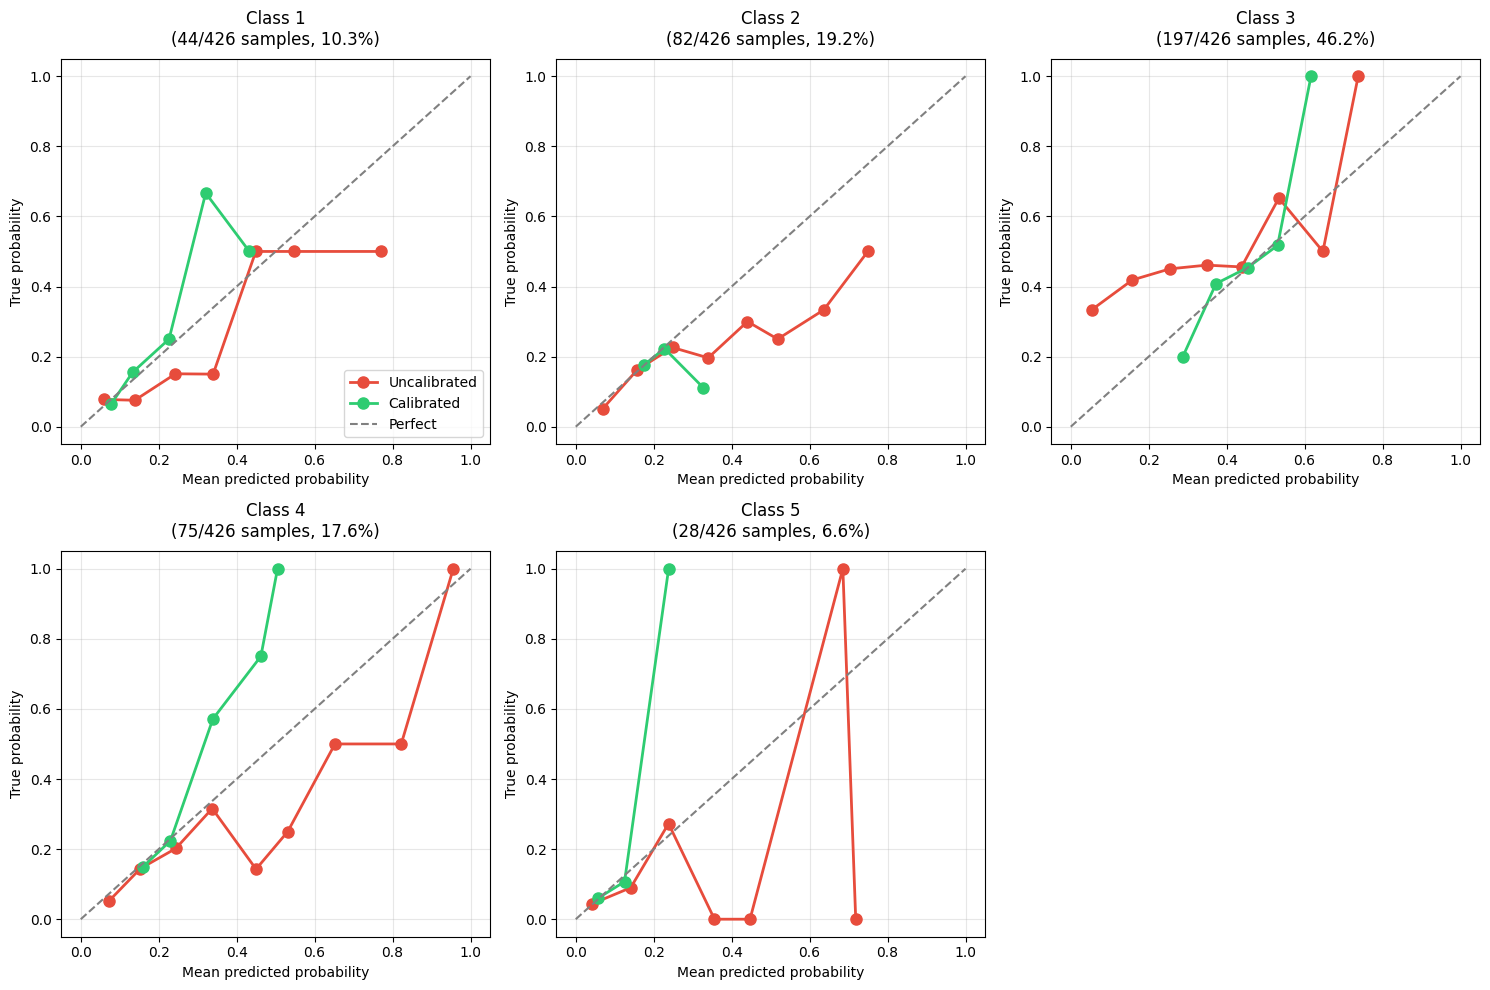

No predictions met the confidence threshold of 0.8
No predictions met the confidence threshold of 0.8
Model saved to: rf_full_slice_multiclass.joblib


In [ ]:
class RandomForestOptimizer:
    def __init__(self, X_train, y_train, X_test, y_test, X_unseen, y_unseen, random_state=42):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_unseen = X_unseen
        self.y_unseen = y_unseen
        self.random_state = random_state
        self.best_model = None
        self.study = None
        self.calibrated_model = None
        self.n_classes = len(np.unique(y_train))
        self.class_weight = 'balanced'
        self.class_labels = list(range(1, 6))  # Classes from 1 to 5

    def objective(self, trial):
        """Objective function for Optuna optimization"""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': self.class_weight,
            'random_state': self.random_state,
            'n_jobs': -1
        }
        
        model = RandomForestClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        try:
            # Using macro F1 score for multi-class
            f1_scores = cross_val_score(
                model, self.X_train, self.y_train, 
                scoring=make_scorer(f1_score, average='macro'),
                cv=cv
            )
            return np.mean(f1_scores)
        except Exception as e:
            print(f"Error during cross validation: {str(e)}")
            return float('-inf')

    def optimize(self, n_trials=100):
        """Run the optimization process"""
        print("\nStarting hyperparameter optimization...")
        print(f"Number of features: {self.X_train.shape[1]}")
        print(f"Number of samples: {self.X_train.shape[0]}")
        print(f"Number of classes: {self.n_classes}")
        print("\nClass distribution:")
        
        # Modified to show distribution for classes 1-5
        class_counts = np.bincount(self.y_train, minlength=6)[1:]  # Skip index 0
        for class_label, count in zip(self.class_labels, class_counts):
            print(f"Class {class_label}: {count}")
        
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=n_trials, show_progress_bar=True)
        self.study = study
        
        best_params = study.best_params
        best_params.update({
            'class_weight': self.class_weight,
            'random_state': self.random_state,
            'n_jobs': -1
        })
        
        print("\nBest parameters:", best_params)
        print(f"Best macro F1-score: {study.best_value:.4f}")
        
        self.best_model = RandomForestClassifier(**best_params)
        self.best_model.fit(self.X_train, self.y_train)
        
        return self

    def calibrate_probabilities(self, cv=5):
        """Calibrate probability estimates using Platt Scaling"""
        if self.best_model is None:
            raise ValueError("Model hasn't been optimized yet. Call optimize() first.")
        
        print("\nCalibrating probability estimates...")
        self.calibrated_model = CalibratedClassifierCV(
            self.best_model, 
            cv=cv, 
            method='sigmoid',
            n_jobs=-1
        )
        self.calibrated_model.fit(self.X_train, self.y_train)
        
        # Calculate calibration metrics for each class (1-5)
        for class_label in self.class_labels:
            # Convert to binary problem for each class
            y_test_binary = (self.y_test == class_label).astype(int)
            prob_pos_test = self.calibrated_model.predict_proba(self.X_test)[:, class_label-1]
            
            brier = brier_score_loss(y_test_binary, prob_pos_test)
            try:
                auc = roc_auc_score(y_test_binary, prob_pos_test)
                print(f"\nClass {class_label} Calibration Metrics:")
                print(f"Brier Score Loss: {brier:.4f} (lower is better)")
                print(f"ROC AUC Score: {auc:.4f}")
            except:
                print(f"\nClass {class_label}: Insufficient samples for ROC AUC calculation")
        
        return self

    def plot_calibration_curves(self):
        """Plot separate calibration curves for each class"""
        if self.calibrated_model is None:
            raise ValueError("Model hasn't been calibrated. Call calibrate_probabilities() first.")
        
        # Calculate number of rows and columns for subplots
        n_rows = 2  # For 5 classes, 3 in first row, 2 in second
        n_cols = 3
        
        # Create figure with subplots
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
        axes = axes.ravel()
        
        # Color scheme
        colors = ['#2ecc71', '#e74c3c']  # Green for calibrated, Red for uncalibrated
        
        for i, class_label in enumerate(self.class_labels):
            ax = axes[i]
            
            # Convert to binary problem for this class
            y_test_binary = (self.y_test == class_label).astype(int)
            
            # Get probabilities (adjust index for 1-based classes)
            prob_pos_uncal = self.best_model.predict_proba(self.X_test)[:, class_label-1]
            prob_pos_cal = self.calibrated_model.predict_proba(self.X_test)[:, class_label-1]
            
            # Calculate calibration curves
            prob_true_uncal, prob_pred_uncal = calibration_curve(
                y_test_binary, prob_pos_uncal, n_bins=10
            )
            prob_true_cal, prob_pred_cal = calibration_curve(
                y_test_binary, prob_pos_cal, n_bins=10
            )
            
            # Plot calibration curves
            ax.plot(prob_pred_uncal, prob_true_uncal, 
                   'o-', color=colors[1], label='Uncalibrated',
                   linewidth=2, markersize=8)
            ax.plot(prob_pred_cal, prob_true_cal, 
                   'o-', color=colors[0], label='Calibrated',
                   linewidth=2, markersize=8)
            ax.plot([0, 1], [0, 1], '--', color='gray', label='Perfect')
            
            # Calculate class distribution
            class_count = np.sum(y_test_binary)
            total_count = len(y_test_binary)
            class_percent = (class_count / total_count) * 100
            
            # Add title and class distribution info
            ax.set_title(f'Class {class_label}\n({class_count}/{total_count} samples, {class_percent:.1f}%)',
                        fontsize=12, pad=10)
            
            # Set labels and grid
            ax.set_xlabel('Mean predicted probability')
            ax.set_ylabel('True probability')
            ax.grid(True, alpha=0.3)
            
            # Add legend only to first subplot
            if i == 0:
                ax.legend(loc='lower right')
            
            # Set axis limits
            ax.set_xlim([-0.05, 1.05])
            ax.set_ylim([-0.05, 1.05])
        
        # Remove extra subplot
        fig.delaxes(axes[5])
        
        plt.tight_layout()
        plt.show()

    def predict_with_confidence(self, X):
        """Make predictions with confidence estimates"""
        if self.calibrated_model is None:
            raise ValueError("Model hasn't been calibrated. Call calibrate_probabilities() first.")
        
        probabilities = self.calibrated_model.predict_proba(X)
        predictions = np.argmax(probabilities, axis=1) + 1  # Add 1 to get classes 1-5
        confidences = np.max(probabilities, axis=1)
        
        return predictions, confidences, probabilities

    def evaluate_with_confidence(self, confidence_threshold=0.8, dataset="test"):
        """Evaluate model performance considering confidence threshold"""
        if self.calibrated_model is None:
            raise ValueError("Model hasn't been calibrated. Call calibrate_probabilities() first.")
        
        # Select evaluation dataset
        if dataset == "test":
            X_eval, y_eval = self.X_test, self.y_test
        elif dataset == "unseen":
            X_eval, y_eval = self.X_unseen, self.y_unseen
        else:
            raise ValueError("dataset must be 'test' or 'unseen'")
        
        # Get predictions and confidences
        y_pred, confidences, _ = self.predict_with_confidence(X_eval)
        
        # Filter predictions based on confidence threshold
        high_confidence_mask = confidences >= confidence_threshold
        
        if np.sum(high_confidence_mask) > 0:
            high_conf_accuracy = accuracy_score(
                y_eval[high_confidence_mask], 
                y_pred[high_confidence_mask]
            )
            high_conf_f1_macro = f1_score(
                y_eval[high_confidence_mask], 
                y_pred[high_confidence_mask], 
                average='macro'
            )
            high_conf_f1_weighted = f1_score(
                y_eval[high_confidence_mask], 
                y_pred[high_confidence_mask], 
                average='weighted'
            )
            coverage = np.mean(high_confidence_mask)
            
            print(f"\nConfidence Threshold Analysis for {dataset} set (threshold = {confidence_threshold}):")
            print(f"Coverage: {coverage:.2%} of samples")
            print(f"High-confidence Accuracy: {high_conf_accuracy:.4f}")
            print(f"High-confidence Macro F1-Score: {high_conf_f1_macro:.4f}")
            print(f"High-confidence Weighted F1-Score: {high_conf_f1_weighted:.4f}")
            
            print("\nDetailed Classification Report for high-confidence predictions:")
            print(classification_report(
                y_eval[high_confidence_mask], 
                y_pred[high_confidence_mask],
                labels=self.class_labels,
                target_names=[f'Class {i}' for i in self.class_labels]
            ))
            
            return {
                'coverage': coverage,
                'high_conf_accuracy': high_conf_accuracy,
                'high_conf_f1_macro': high_conf_f1_macro,
                'high_conf_f1_weighted': high_conf_f1_weighted,
                'confidence_threshold': confidence_threshold
            }
        else:
            print(f"No predictions met the confidence threshold of {confidence_threshold}")
            return None

    def save_model(self, filepath):
        """Save the calibrated model"""
        if self.calibrated_model is None:
            raise ValueError("No calibrated model to save. Run calibrate_probabilities() first.")
        
        joblib.dump(self.calibrated_model, filepath)
        print(f"Model saved to: {filepath}")

    @staticmethod
    def load_model(filepath):
        """Load a saved model"""
        model = joblib.load(filepath)
        print(f"Model loaded from: {filepath}")
        return model

# Example usage:
rf_optimizer = RandomForestOptimizer(
    X_train_fs, y_train_fs,
    X_test_fs, y_test_fs,
    X_unseen_fs_imputed, y_unseen_fs
)

# Optimization
rf_optimizer.optimize(n_trials=100)

# Calibration and evaluation
rf_optimizer.calibrate_probabilities()
rf_optimizer.plot_calibration_curves()

# Evaluation on test and unseen sets
test_results = rf_optimizer.evaluate_with_confidence(confidence_threshold=0.8, dataset="test")
unseen_results = rf_optimizer.evaluate_with_confidence(confidence_threshold=0.8, dataset="unseen")

# Save the model
rf_optimizer.save_model('rf_full_slice_multiclass.joblib')

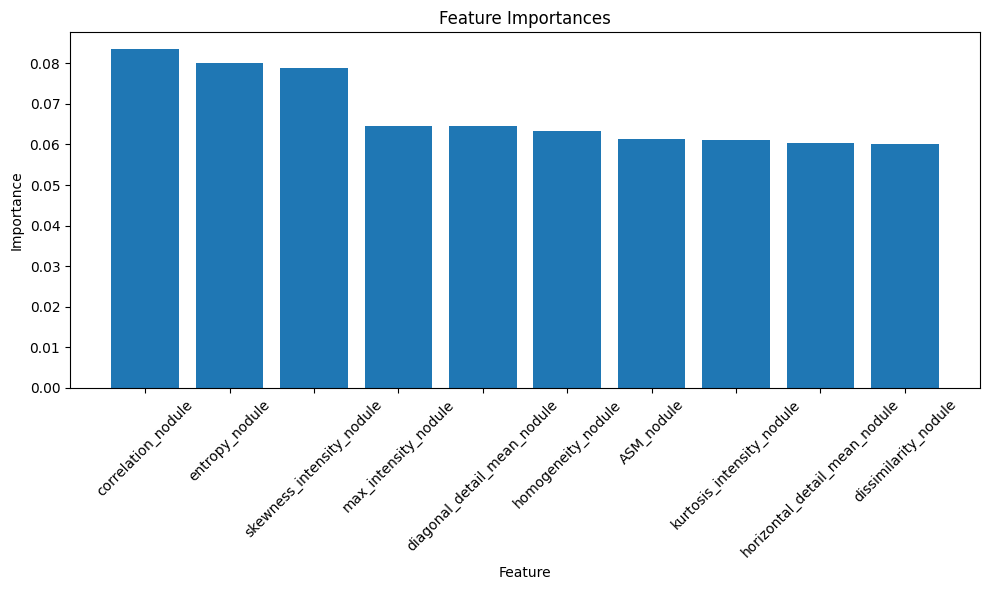

In [94]:
plot_feature_importances(rf_optimizer.best_model, np.array(X_test_nod_binary.columns))


# 6. Binary Classification Task Nodule

## RandomForest :

[I 2025-01-11 15:21:40,886] A new study created in memory with name: no-name-5d912b65-ae74-4efb-84b7-b43b7d550614


Starting hyperparameter optimization...
Number of features: 31
Number of samples: 1700
Class distribution: [1290  410]


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-01-11 15:21:44,561] Trial 0 finished with value: 0.8330988487153201 and parameters: {'n_estimators': 277, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.8330988487153201.
[I 2025-01-11 15:21:49,912] Trial 1 finished with value: 0.8310581057673462 and parameters: {'n_estimators': 382, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8330988487153201.
[I 2025-01-11 15:21:54,592] Trial 2 finished with value: 0.8322003859772898 and parameters: {'n_estimators': 303, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8330988487153201.
[I 2025-01-11 15:22:01,656] Trial 3 finished with value: 0.8328608905929358 and parameters: {'n_estimators': 455, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_featu

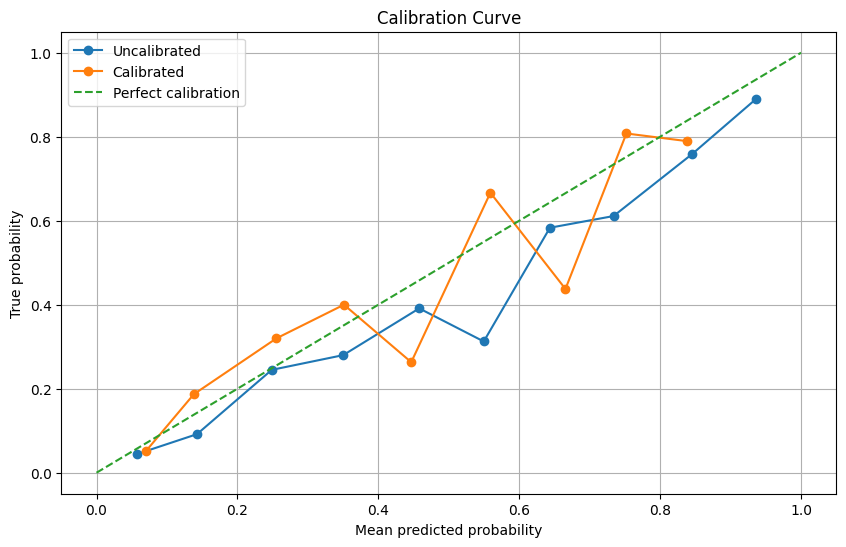


Confidence Threshold Analysis (threshold = 0.8):
Coverage: 71.36% of samples
High-confidence Accuracy: 0.8980
High-confidence F1-Score: 0.8809

Training the model with the best parameters on the full dataset...
Training on the full dataset is complete.
Model saved to: rf_nodule_binary.joblib


In [29]:


warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)


rf_optimizer = RandomForestOptimizer(X_train_nod_binary, y_train_nod_binary,X_test_nod_binary, y_test_nod_binary,X_unseen_nod_binary, y_unseen_nod_binary)
rf_optimizer.optimize(n_trials=100)

rf_optimizer.calibrate_probabilities()
rf_optimizer.plot_calibration_curve()

results = rf_optimizer.evaluate_with_confidence(confidence_threshold=0.8)

new_predictions, confidences, probabilities = rf_optimizer.predict_with_confidence(X_unseen_nod_binary)


rf_optimizer.train_with_best_params()

rf_optimizer.save_model('rf_nodule_binary.joblib')

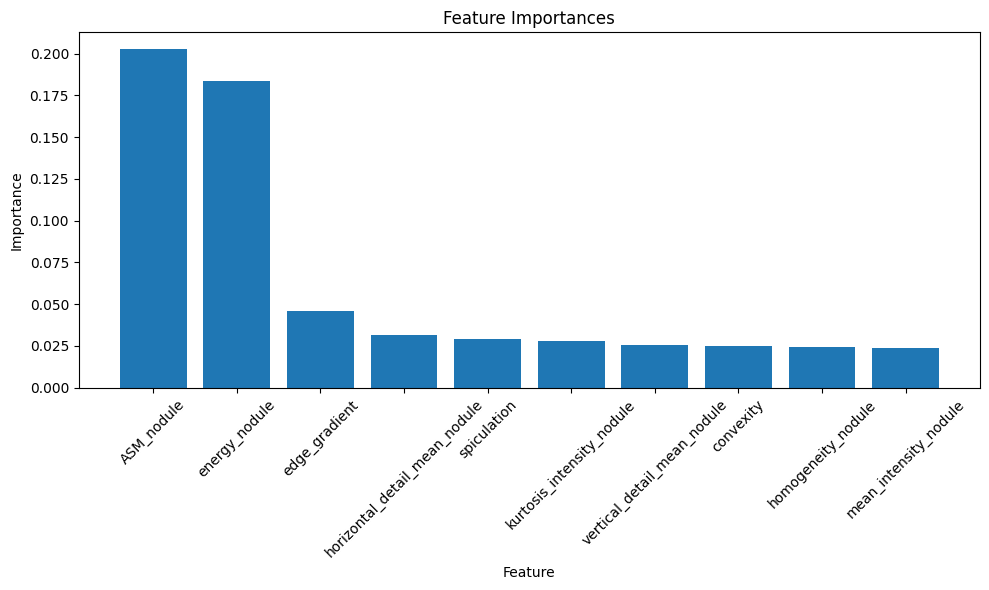

In [96]:
import matplotlib.pyplot as plt

plot_feature_importances(rf_optimizer.best_model, np.array(X_test_nod_binary.columns))
